In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 22.9 MB/s eta 0:00:00


In [ ]:
# !pip install keras-tuner

from google.colab import drive
drive.mount('/content/drive')

# Commented out IPython magic to ensure Python compatibility.
import os
import sys
import time
import glob
import random
import argparse
import pickle
import numpy as np
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import lfilter
import scipy.signal as signal
from sklearn.utils import shuffle, compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, Add, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Flatten,
    Conv2D, DepthwiseConv2D, MaxPooling2D,
    BatchNormalization, GlobalAveragePooling2D,
    Add
)
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Conv2D, DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D,
    Dense, Dropout, Add, ReLU
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

%matplotlib inline

class DataSet2(object):

    def __init__(self, images, labels, img_names, cls):
        self._num_examples = images.shape[0]

        self._images = images
        self._labels = labels
        self._img_names = img_names
        self._cls = cls
        self._epochs_done = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def img_names(self):
        return self._img_names

    @property
    def cls(self):
        return self._cls

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_done(self):
        return self._epochs_done

    def next_batch(self, batch_size):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            self._epochs_done += 1
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end], self._img_names[start:end], self._cls[start:end]

def read_train_sets2(train_path, classes, validation_size):
    class DataSets(object):
        pass

    data_sets = DataSets()

    images, labels, img_names, cls = load_train2(train_path, classes)  # 2 calculating, 3 loading
    images, labels, img_names, cls = shuffle(images, labels, img_names, cls)

    if isinstance(validation_size, float):
        validation_size = int(validation_size * images.shape[0])

    validation_images = images[:validation_size]
    validation_labels = labels[:validation_size]
    validation_img_names = img_names[:validation_size]
    validation_cls = cls[:validation_size]

    train_images = images[validation_size:]
    train_labels = labels[validation_size:]
    train_img_names = img_names[validation_size:]
    train_cls = cls[validation_size:]
#     print('Training dataset shape:',len (train_images))
    data_sets.train = DataSet2(train_images, train_labels, train_img_names, train_cls)
    data_sets.valid = DataSet2(validation_images, validation_labels, validation_img_names, validation_cls)

    return data_sets

def load_train2(train_path, classes):
    samples = []
    labels = []
    sample_names = []
    cls = []

    for fields in classes:
        index = classes.index(fields)
        path = os.path.join(train_path, fields, '*.npy')
        files = glob.glob(path)
        for fl in files:
            iq_samples = np.load(fl)
            real = np.real(iq_samples)
            imag = np.imag(iq_samples)

            iq_samples = np.ravel(np.column_stack((real, imag)))

            multiple = False
            if multiple:
                iq_samples1 = iq_samples[:1568]
                iq_samples1 = iq_samples1.reshape(28, 28, 2)
                iq_samples2 = iq_samples[1568:3136]
                iq_samples2 = iq_samples2.reshape(28, 28, 2)
                iq_samples3 = iq_samples[3136:4704]
                iq_samples3 = iq_samples3.reshape(28, 28, 2)
                iq_samples4 = iq_samples[4704:6272]
                iq_samples4 = iq_samples4.reshape(28, 28, 2)
                samples.append(iq_samples1)
                samples.append(iq_samples2)
                samples.append(iq_samples3)
                samples.append(iq_samples4)

                flbase = os.path.basename(fl)
                label = np.zeros(len(classes))
                label[index] = 1.0

                labels.append(label)
                labels.append(label)
                labels.append(label)
                labels.append(label)
                sample_names.append(flbase)
                sample_names.append(flbase)
                sample_names.append(flbase)
                sample_names.append(flbase)
                cls.append(fields)
                cls.append(fields)
                cls.append(fields)
                cls.append(fields)
            else:
                iq_samples = iq_samples[:1568]
                iq_samples = iq_samples.reshape(28, 28, 2)
                samples.append(iq_samples)

                label = np.zeros(len(classes))
                label[index] = 1.0
                labels.append(label)
                flbase = os.path.basename(fl)
                sample_names.append(flbase)
                cls.append(fields)

    samples = np.array(samples)
    labels = np.array(labels)
    sample_names = np.array(sample_names)
    cls = np.array(cls)
    return samples, labels, sample_names, cls

# Function to read the samples from _prediction_samples.dat files

def read_samples_sdr(freq):
    sdr = RtlSdr()
    sdr.sample_rate = sample_rate
    sdr.err_ppm = 56   # change it to yours
    sdr.gain = 'auto'

    f_offset = 250000  # shifted tune to avoid DC
    sdr.center_freq = freq - f_offset
    time.sleep(0.06)
    iq_samples = sdr.read_samples(1221376)
    iq_samples = iq_samples[0:600000]
    fc1 = np.exp(-1.0j * 2.0 * np.pi * f_offset / sample_rate * np.arange(len(iq_samples)))  # shift down 250kHz
    iq_samples = iq_samples * fc1
    return iq_samples


def read_samples(freq):
    f_offset = 250000  # Shifted tune to avoid DC
    samp = np.fromfile(str(freq)+'_prediction_samples.dat',np.uint8)+np.int8(-127) # Adding a signed int8 to an unsigned one results in an int16 array
    x1 = samp[::2]/128 # Even samples are real(In-phase)
    x2 = samp[1::2]/128 # Odd samples are imaginary(Quadrature-phase)
    iq_samples = x1+x2*1j # Create the complex data samples
    iq_samples = iq_samples[0:600000]
    fc1 = np.exp(-1.0j * 2.0 * np.pi * f_offset / sample_rate * np.arange(len(iq_samples)))  # Shift down 250kHz
    iq_samples = iq_samples * fc1
    return iq_samples

########### Main Code #################################

############ Data for training the model #################
train_path ='/content/drive/MyDrive/rfsc-dataset/Dataset_Deep_Radio/Dataset_Deep_Radio/training_data'
classes = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))] # Gets classes from all the folders mentioned under training_data folder
print(classes)
# classes = ['BPSK','GMSK','QPSK']
num_classes = len(classes)
data = read_train_sets2(train_path, classes, validation_size=0.2) # Gets the data object using a class in dataset2.py

Xtrain = data.train.images
Ytrain = data.train.labels
Xtest = data.valid.images
Ytest = data.valid.labels

print('Training dataset shape:',Xtrain.shape)
print('Training dataset label:',Ytrain.shape)
print('Testing dataset shape:',Xtest.shape)
print('Testing dataset label:',Ytest.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['16QAM', '64QAM', 'BPSK', 'CPFSK', 'GFSK', 'GMSK', 'OTHER', 'QPSK']
Training dataset shape: (2400, 28, 28, 2)
Training dataset label: (2400, 8)
Testing dataset shape: (600, 28, 28, 2)
Testing dataset label: (600, 8)


In [ ]:
# setting np and tf random seed
SEED = 50
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Conv2D, DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D,
    Dense, Dropout, Add, ReLU
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import numpy as np


# -----------------------------
# Model definition
# -----------------------------
class EnhancedOptimizedCNN:
    def __init__(self, input_shape, num_classes, alpha):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.alpha = alpha
        self.model = None

    def _inverted_residual_block_v2(self, x, filters, strides, expand_ratio, alpha, dropout_rate):
        input_channels = int(x.shape[-1])
        expanded_channels = int(input_channels * expand_ratio * alpha)
        output_channels = int(filters * alpha)

        if expand_ratio != 1:
            x_expanded = Conv2D(expanded_channels, (1, 1), padding='same', use_bias=False)(x)
            x_expanded = BatchNormalization()(x_expanded)
            x_expanded = ReLU(max_value=6.0)(x_expanded)
            x_expanded = Dropout(dropout_rate)(x_expanded)
        else:
            x_expanded = x

        x_dw = DepthwiseConv2D((3, 3), strides=strides, padding='same', use_bias=False)(x_expanded)
        x_dw = BatchNormalization()(x_dw)
        x_dw = ReLU(max_value=6.0)(x_dw)

        x_proj = Conv2D(output_channels, (1, 1), padding='same', use_bias=False)(x_dw)
        x_proj = BatchNormalization()(x_proj)

        if strides == 1 and input_channels == output_channels:
            x_proj = Dropout(dropout_rate / 2)(x_proj)
            return Add()([x, x_proj])
        else:
            return x_proj

    def _build_enhanced_model(self, dropout_rates):
        inputs = Input(shape=self.input_shape)

        x = Conv2D(int(12 * self.alpha), (3, 3), strides=1, padding='same', use_bias=False)(inputs)
        x = BatchNormalization()(x)
        x = ReLU(max_value=6.0)(x)
        x = Dropout(dropout_rates[0])(x)

        x = self._inverted_residual_block_v2(x, 20, strides=2, expand_ratio=1,
                                             alpha=self.alpha, dropout_rate=dropout_rates[1])
        x = self._inverted_residual_block_v2(x, 24, strides=1, expand_ratio=2,
                                             alpha=self.alpha, dropout_rate=dropout_rates[2])
        x = self._inverted_residual_block_v2(x, 48, strides=2, expand_ratio=2,
                                             alpha=self.alpha, dropout_rate=dropout_rates[3])
        x = self._inverted_residual_block_v2(x, 64, strides=1, expand_ratio=2,
                                             alpha=self.alpha, dropout_rate=dropout_rates[4])

        x = GlobalAveragePooling2D()(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(dropout_rates[5])(x)

        outputs = Dense(self.num_classes, activation='softmax')(x)
        return Model(inputs, outputs, name='EnhancedOptimizedCNN_AdamW')

    def create_model(self, dropout_rates):
        self.model = self._build_enhanced_model(dropout_rates)
        return self.model


# -----------------------------
# Augmentation
# -----------------------------
class AdvancedRFAugmentation:
    def __init__(self, snr_range, augmentation_factor, seed=42):
        self.snr_range = snr_range
        self.augmentation_factor = augmentation_factor
        self.rng = np.random.RandomState(seed)  # deterministic random generator

    def add_awgn(self, signal, snr_db):
        snr_linear = 10.0 ** (snr_db / 10.0)
        if signal.shape[-1] == 2:
            signal_power = np.mean(signal[:, :, 0] ** 2 + signal[:, :, 1] ** 2)
        else:
            signal_power = np.mean(signal ** 2)
        noise_power = signal_power / snr_linear
        noise_std = np.sqrt(noise_power / 2)

        if self.rng.random() > 0.8:
            white_noise = self.rng.normal(0, noise_std, signal.shape)
            colored_noise = np.zeros_like(white_noise)
            for i in range(1, signal.shape[0]):
                colored_noise[i] = 0.7 * colored_noise[i - 1] + 0.3 * white_noise[i]
            noise = colored_noise
        else:
            noise = self.rng.normal(0, noise_std, signal.shape)

        return (signal + noise).astype(np.float32)

    def add_frequency_selective_fading(self, signal):
        if signal.shape[-1] != 2:
            return signal
        if self.rng.random() > 0.7:
            delay = self.rng.randint(1, 4)
            amplitude = self.rng.uniform(0.3, 0.7)
            delayed_signal = np.roll(signal, delay, axis=0) * amplitude
            return signal + delayed_signal
        return signal

    def add_phase_noise(self, signal, phase_std=0.15):
        if signal.shape[-1] != 2:
            return signal
        phase_noise = self.rng.normal(0, phase_std, signal.shape[:2])
        for i in range(1, signal.shape[0]):
            phase_noise[i] = 0.9 * phase_noise[i - 1] + 0.1 * phase_noise[i]
        cos_noise = np.cos(phase_noise)
        sin_noise = np.sin(phase_noise)
        i_noisy = signal[:, :, 0] * cos_noise - signal[:, :, 1] * sin_noise
        q_noisy = signal[:, :, 0] * sin_noise + signal[:, :, 1] * cos_noise
        result = signal.copy()
        result[:, :, 0] = i_noisy
        result[:, :, 1] = q_noisy
        return result

    def augment_batch_enhanced(self, signals, labels):
        augmented_signals, augmented_labels = [], []
        for i in range(len(signals)):
            augmented_signals.append(signals[i])
            augmented_labels.append(labels[i])
            for _ in range(self.augmentation_factor):
                snr_db = self.rng.uniform(self.snr_range[0], self.snr_range[1])
                augmented_signal = self.add_awgn(signals[i], snr_db)
                if self.rng.random() > 0.6:
                    augmented_signal = self.add_frequency_selective_fading(augmented_signal)
                if self.rng.random() > 0.7:
                    augmented_signal = self.add_phase_noise(augmented_signal)
                augmented_signals.append(augmented_signal)
                augmented_labels.append(labels[i])
        return np.array(augmented_signals), np.array(augmented_labels)


# -----------------------------
# Training pipeline
# -----------------------------
class ClassWeightedTrainingPipeline:
    def __init__(self, model, augmentor, classes):
        self.model = model
        self.augmentor = augmentor
        self.classes = classes
        self.history = None

    def compute_class_weights(self, y_train):
        y_train_labels = np.argmax(y_train, axis=1)
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
        return dict(enumerate(class_weights))

    def create_enhanced_callbacks(self, checkpoint_path, patience_es, patience_lr, min_delta):
        return [
            EarlyStopping(monitor='val_loss', patience=patience_es, restore_best_weights=True, verbose=1, min_delta=min_delta),
            ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=patience_lr, min_lr=1e-8, verbose=1, cooldown=1),
            ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1, mode='min')
        ]

    def train_enhanced_model(self, X_train, y_train, Xtest, Ytest,
                             epochs, batch_size, lr, weight_decay,
                             beta_1, beta_2,
                             patience_es, patience_lr, min_delta, checkpoint_path):

        X_train_aug, y_train_aug = self.augmentor.augment_batch_enhanced(X_train, y_train)
        class_weights = self.compute_class_weights(y_train_aug)
        callbacks = self.create_enhanced_callbacks(checkpoint_path, patience_es, patience_lr, min_delta)

        try:
            optimizer = tf.keras.optimizers.AdamW(
                learning_rate=lr,
                weight_decay=weight_decay,
                beta_1=beta_1,
                beta_2=beta_2
            )
        except Exception:
            import tensorflow_addons as tfa
            optimizer = tfa.optimizers.AdamW(
                learning_rate=lr,
                weight_decay=weight_decay,
                beta_1=beta_1,
                beta_2=beta_2,
            )

        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        self.history = self.model.fit(
            X_train_aug, y_train_aug,
            validation_data=(Xtest, Ytest),
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weights,
            callbacks=callbacks,
            verbose=1,
            shuffle=True
        )
        return self.history


In [ ]:
# ===== MODEL HYPERPARAMS =====
input_shape = (28, 28, 2)
num_classes = num_classes
alpha = 0.9
# dropout_rates = [0.1, 0.1, 0.15, 0.2, 0.25, 0.5]
dropout_rates = [0.06, 0.07, 0.17, 0.24, 0.26, 0.44]

# ===== AUGMENTATION HYPERPARAMS =====
snr_range = (-5, 25)
augmentation_factor = 6

# ===== TRAINING HYPERPARAMS =====
epochs = 100
batch_size = 32
learning_rate = 2e-4
weight_decay = 1e-4
beta_1 = 0.9
beta_2 = 0.98

patience_es = 6
patience_lr = 3
min_delta = 5e-4
checkpoint_path = "enhanced_best_model.keras"

  # alpha: 0.9391173067306237
  # learning_rate: 0.0002
  # weight_decay: 0.0001
  # beta_1: 0.9
  # beta_2: 0.98
  # dropout0: 0.06349751097398268
  # dropout1: 0.07010274653891013
  # dropout2: 0.17768777092923518
  # dropout3: 0.24692303454847042
  # dropout4: 0.26457969324212377
  # dropout_final: 0.44150598695684135

In [ ]:
# ===== MODEL CREATION =====
enhanced_cnn = EnhancedOptimizedCNN(input_shape=input_shape, num_classes=num_classes, alpha=alpha)
enhanced_model = enhanced_cnn.create_model(dropout_rates)
enhanced_model.summary()

# ===== AUGMENTOR =====
enhanced_augmentor = AdvancedRFAugmentation(snr_range=snr_range, augmentation_factor=augmentation_factor)

# ===== TRAINING PIPELINE =====
enhanced_pipeline = ClassWeightedTrainingPipeline(enhanced_model, enhanced_augmentor, classes)

Model: "EnhancedOptimizedCNN_AdamW"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 28, 28, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_208 (Conv2D)             │ (None, 28, 28, 10)     │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_312         │ (None, 28, 28, 10)     │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_208 (ReLU)                │ (None, 28, 28, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (None, 28, 28, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_104            │ (None, 14, 14, 10)     │            90 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_313         │ (None, 14, 14, 10)     │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_209 (ReLU)                │ (None, 14, 14, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_209 (Conv2D)             │ (None, 14, 14, 18)     │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_314         │ (None, 14, 14, 18)     │            72 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_210 (Conv2D)             │ (None, 14, 14, 32)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_315         │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_210 (ReLU)                │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_131 (Dropout)           │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_105            │ (None, 14, 14, 32)     │           288 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_316         │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_211 (ReLU)                │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_211 (Conv2D)             │ (None, 14, 14, 21)     │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_317         │ (None, 14, 14, 21)     │            84 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_212 (Conv2D)             │ (None, 14, 14, 37)     │           777 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_318         │ (None, 14, 14, 37)     │           14

 Total params: 17,004 (66.42 KB)

 Trainable params: 16,102 (62.90 KB)

 Non-trainable params: 902 (3.52 KB)

Epoch 1/100
518/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2535 - loss: 1.8863
Epoch 1: val_loss improved from inf to 2.31036, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.2544 - loss: 1.8842 - val_accuracy: 0.1933 - val_loss: 2.3104 - learning_rate: 2.0000e-04
Epoch 2/100
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4122 - loss: 1.5168
Epoch 2: val_loss improved from 2.31036 to 1.58964, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.4124 - loss: 1.5161 - val_accuracy: 0.3350 - val_loss: 1.5896 - learning_rate: 2.0000e-04
Epoch 3/100
518/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4682 - loss: 1.3720
Epoch 3: val_loss improved from 1.58964 to 1.39245, saving model to enhanced_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4684 - loss: 1.3714 - val_accuracy: 0.4250 - val_loss: 1.3925 - learning_rate: 2.0000e-04
Epoch 4/100
521/525 ━━━

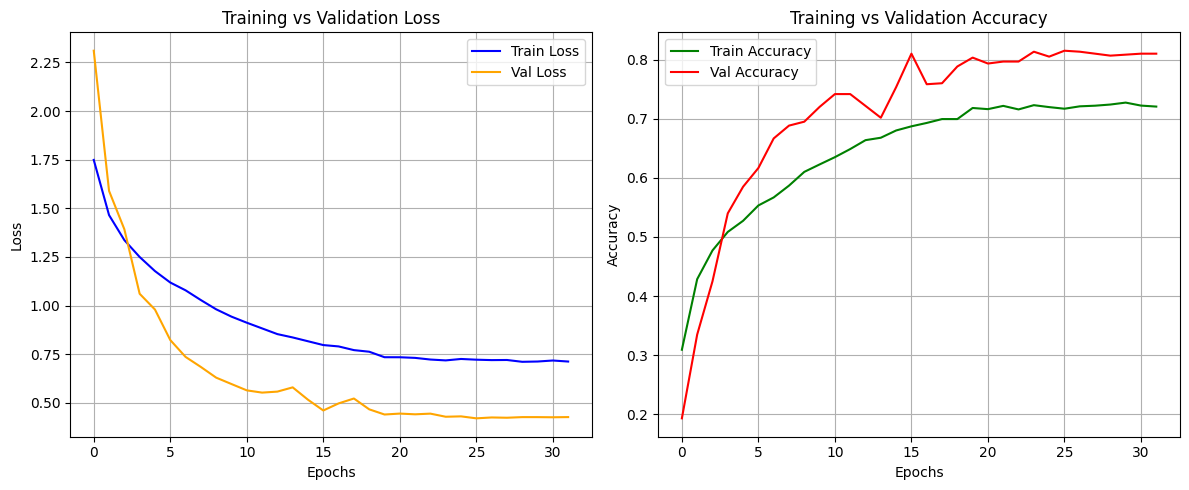

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
Test Accuracy: 0.8150
Test F1-score: 0.8102


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# ===== TRAINING =====
history = enhanced_pipeline.train_enhanced_model(
    X_train=Xtrain,
    y_train=Ytrain,
    Xtest=Xtest,
    Ytest=Ytest,
    epochs=epochs,
    batch_size=batch_size,
    lr=learning_rate,
    weight_decay=weight_decay,
    beta_1=beta_1,
    beta_2=beta_2,
    patience_es=patience_es,
    patience_lr=patience_lr,
    min_delta=min_delta,
    checkpoint_path=checkpoint_path
)

# ===== PLOTS =====
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='red')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ===== TEST METRICS =====
y_pred_probs = enhanced_model.predict(Xtest)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Ytest, axis=1)

test_accuracy = accuracy_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-score: {test_f1:.4f}")


In [ ]:
# FLOPs counter for TF2 Keras models
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def get_flops(model: tf.keras.Model, batch_size: int = 1) -> int:
    """
    Returns the approximate number of floating-point operations (FLOPs)
    for a single forward pass of `batch_size` samples through `model`.
    Note: different profilers may count ops slightly differently.
    """
    # Make sure model is built (has defined input shape)
    if not model.built:
        # try to build with an example input
        input_shape = [batch_size] + list(model.input.shape[1:])
        model.build(input_shape)

    # Create a concrete function from the Keras model
    input_spec = tf.TensorSpec([batch_size] + list(model.input.shape[1:]), model.inputs[0].dtype)
    func = tf.function(lambda x: model(x))
    concrete_func = func.get_concrete_function(input_spec)

    # Convert to a frozen graph
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()

    # Import the graph_def into a new Graph and run the v1 profiler
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')

        with tf.compat.v1.Session(graph=graph) as sess:
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

            # profile the graph to get float ops
            flops = tf.compat.v1.profiler.profile(
                graph=graph,
                run_meta=run_meta,
                cmd='op',
                options=opts
            )
            if flops is None:
                return 0
            return flops.total_float_ops

# Example usage:
# Assuming `model` is your Keras model (already created and compiled)
flops = get_flops(enhanced_model, batch_size=1)
print(f"FLOPs: {flops:,}  ({flops/1e9:.6f} GFLOPs) ")
print(f"Parameters: {enhanced_model.count_params():,}")


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


FLOPs: 3,300,776  (0.003301 GFLOPs) 
Parameters: 22,724


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import numpy as np

# Predictions
y_pred_probs = enhanced_model.predict(Xtest)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Ytest, axis=1)

# Compute metrics
acc = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print("\nMODEL EVALUATION METRICS")
print("=" * 40)
print(f"Accuracy   : {acc:.4f}")
print(f"Precision  : {precision:.4f}")
print(f"Recall     : {recall:.4f}")
print(f"F1-score   : {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

MODEL EVALUATION METRICS
Accuracy   : 0.8683
Precision  : 0.8775
Recall     : 0.8683
F1-score   : 0.8663

Classification Report:
              precision    recall  f1-score   support

       16QAM       0.95      0.95      0.95        79
       64QAM       0.78      0.94      0.85        90
        BPSK       0.94      0.91      0.92        64
       CPFSK       0.93      0.94      0.94        72
        GFSK       0.60      0.66      0.63        73
        GMSK       0.94      0.59      0.72        78
       OTHER       1.00      1.00      1.00        73
        QPSK       0.91      0.96      0.93        71

    accuracy                           0.87       600
   macro avg       0.88      0.87      0.87       600
weighted avg       0.88      0.87      0.87       600

Confusion Matrix:
 [[75  0  3  0  0  0  0  1]
 [ 4 85  0  0  1  0  0  0]
 [ 0  0 58  1  0  0  0  5]
 [ 0  0  0 68  0  3  0  1]
 [ 0 23  1  1 48  0  0  0]
 [ 0  1  0  0 31 46  0  0

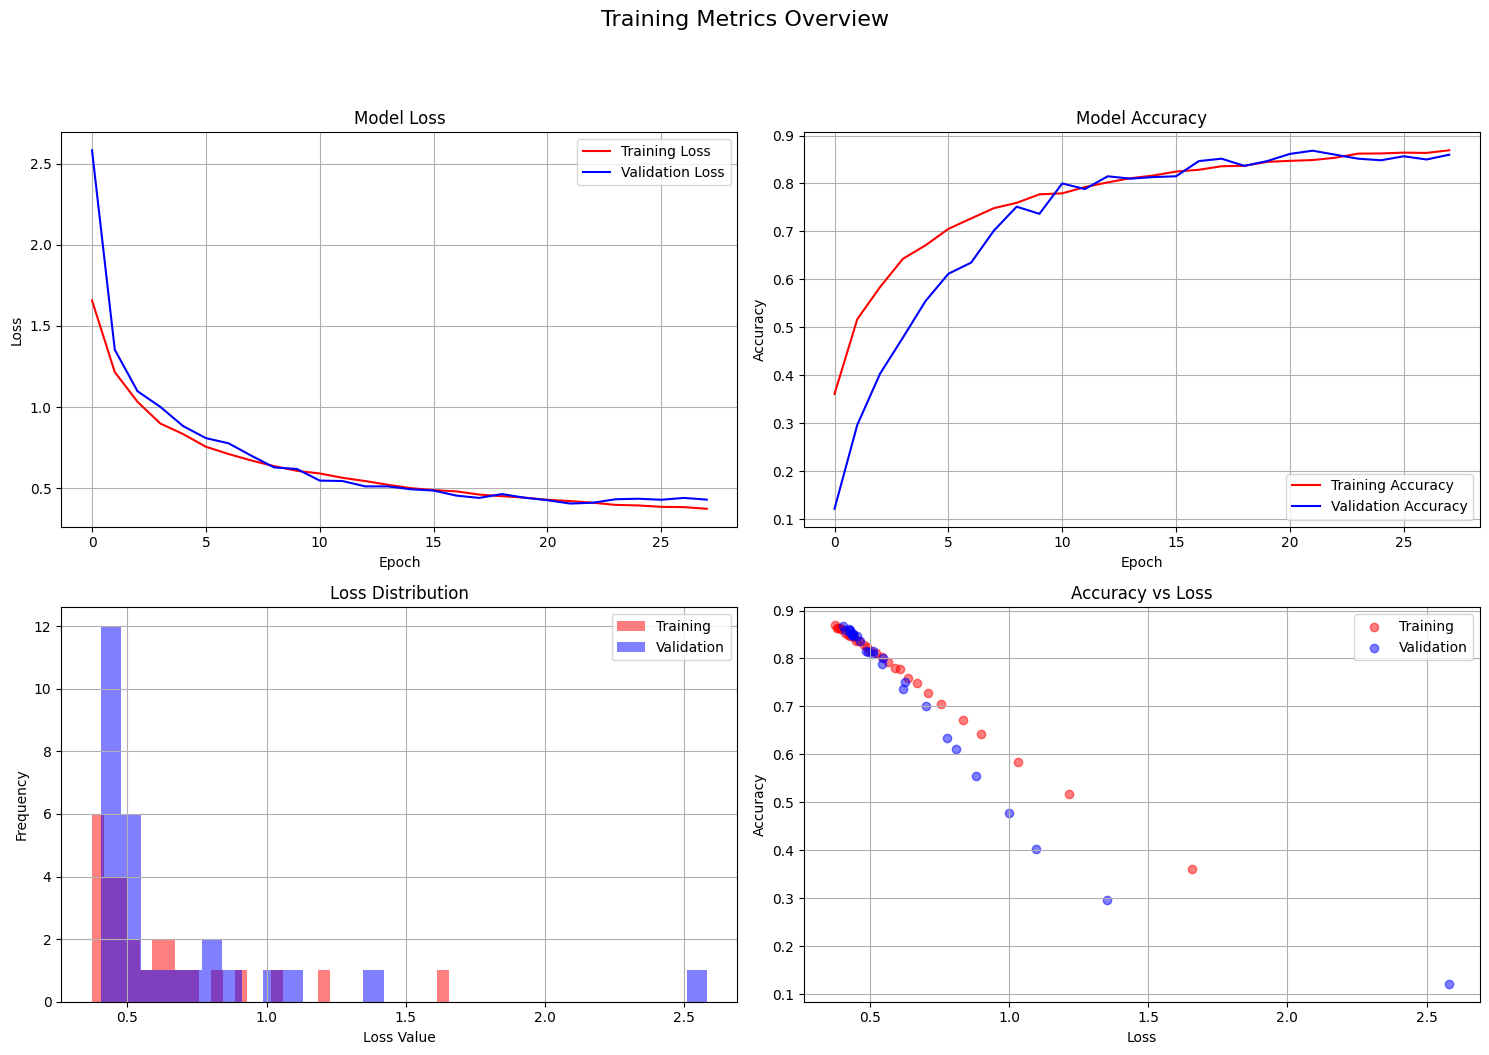


Final Training Metrics:
--------------------------------------------------
Final Training Loss: 0.3729
Final Validation Loss: 0.4294
Final Training Accuracy: 0.8692
Final Validation Accuracy: 0.8600

Model Improvement:
--------------------------------------------------
Loss Improvement: 1.2835
Accuracy Improvement: 0.5082


In [ ]:
enhanced_history = history

def plot_training_metrics(history_dict):
    """
    Plot comprehensive training metrics including loss, accuracy, and learning rate
    """
    metrics = ['loss', 'accuracy']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training Metrics Overview', fontsize=16, y=1.05)

    # Plot loss
    ax = axes[0, 0]
    ax.plot(history_dict['loss'], label='Training Loss', color='red')
    ax.plot(history_dict['val_loss'], label='Validation Loss', color='blue')
    ax.set_title('Model Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right')
    ax.grid(True)

    # Plot accuracy
    ax = axes[0, 1]
    ax.plot(history_dict['accuracy'], label='Training Accuracy', color='red')
    ax.plot(history_dict['val_accuracy'], label='Validation Accuracy', color='blue')
    ax.set_title('Model Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')
    ax.grid(True)

    # Plot loss distribution
    ax = axes[1, 0]
    ax.hist(history_dict['loss'], bins=30, alpha=0.5, color='red', label='Training')
    ax.hist(history_dict['val_loss'], bins=30, alpha=0.5, color='blue', label='Validation')
    ax.set_title('Loss Distribution')
    ax.set_xlabel('Loss Value')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True)

    # Plot accuracy vs loss
    ax = axes[1, 1]
    ax.scatter(history_dict['loss'], history_dict['accuracy'],
              c='red', alpha=0.5, label='Training')
    ax.scatter(history_dict['val_loss'], history_dict['val_accuracy'],
              c='blue', alpha=0.5, label='Validation')
    ax.set_title('Accuracy vs Loss')
    ax.set_xlabel('Loss')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print("\nFinal Training Metrics:")
    print("-" * 50)
    print(f"Final Training Loss: {history_dict['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history_dict['val_loss'][-1]:.4f}")
    print(f"Final Training Accuracy: {history_dict['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history_dict['val_accuracy'][-1]:.4f}")

    # Calculate improvement
    print("\nModel Improvement:")
    print("-" * 50)
    print(f"Loss Improvement: {history_dict['loss'][0] - history_dict['loss'][-1]:.4f}")
    print(f"Accuracy Improvement: {history_dict['accuracy'][-1] - history_dict['accuracy'][0]:.4f}")

# Use the function after training
plot_training_metrics(enhanced_history.history)

Primary test path not found: C:\Users\Jehan_140826\Downloads\rfsc-dataset\Dataset_Deep_Radio\Dataset_Deep_Radio\testing_data
Trying alternative paths...
Found test data at: /content/drive/MyDrive/rfsc-dataset/Dataset_Deep_Radio/Dataset_Deep_Radio/testing_data
🔍 COMPREHENSIVE TEST DATA EVALUATION
Using test data from: /content/drive/MyDrive/rfsc-dataset/Dataset_Deep_Radio/Dataset_Deep_Radio/testing_data
🔄 Loading test data from separate test dataset...
Test data path: /content/drive/MyDrive/rfsc-dataset/Dataset_Deep_Radio/Dataset_Deep_Radio/testing_data
📁 Found test classes: ['16QAM', '64QAM', 'BPSK', 'CPFSK', 'GFSK', 'GMSK', 'OTHER', 'QPSK']
  📊 16QAM: 125 samples
  📊 64QAM: 125 samples
  📊 BPSK: 125 samples
  📊 CPFSK: 125 samples
  📊 GFSK: 125 samples
  📊 GMSK: 125 samples
  📊 OTHER: 125 samples
  📊 QPSK: 125 samples

✅ Test data loaded successfully!
   • Total test samples: 1000
   • Input shape: (1000, 28, 28, 2)
   • Label shape: (1000, 8)
   • Number of classes: 8

Using optimized

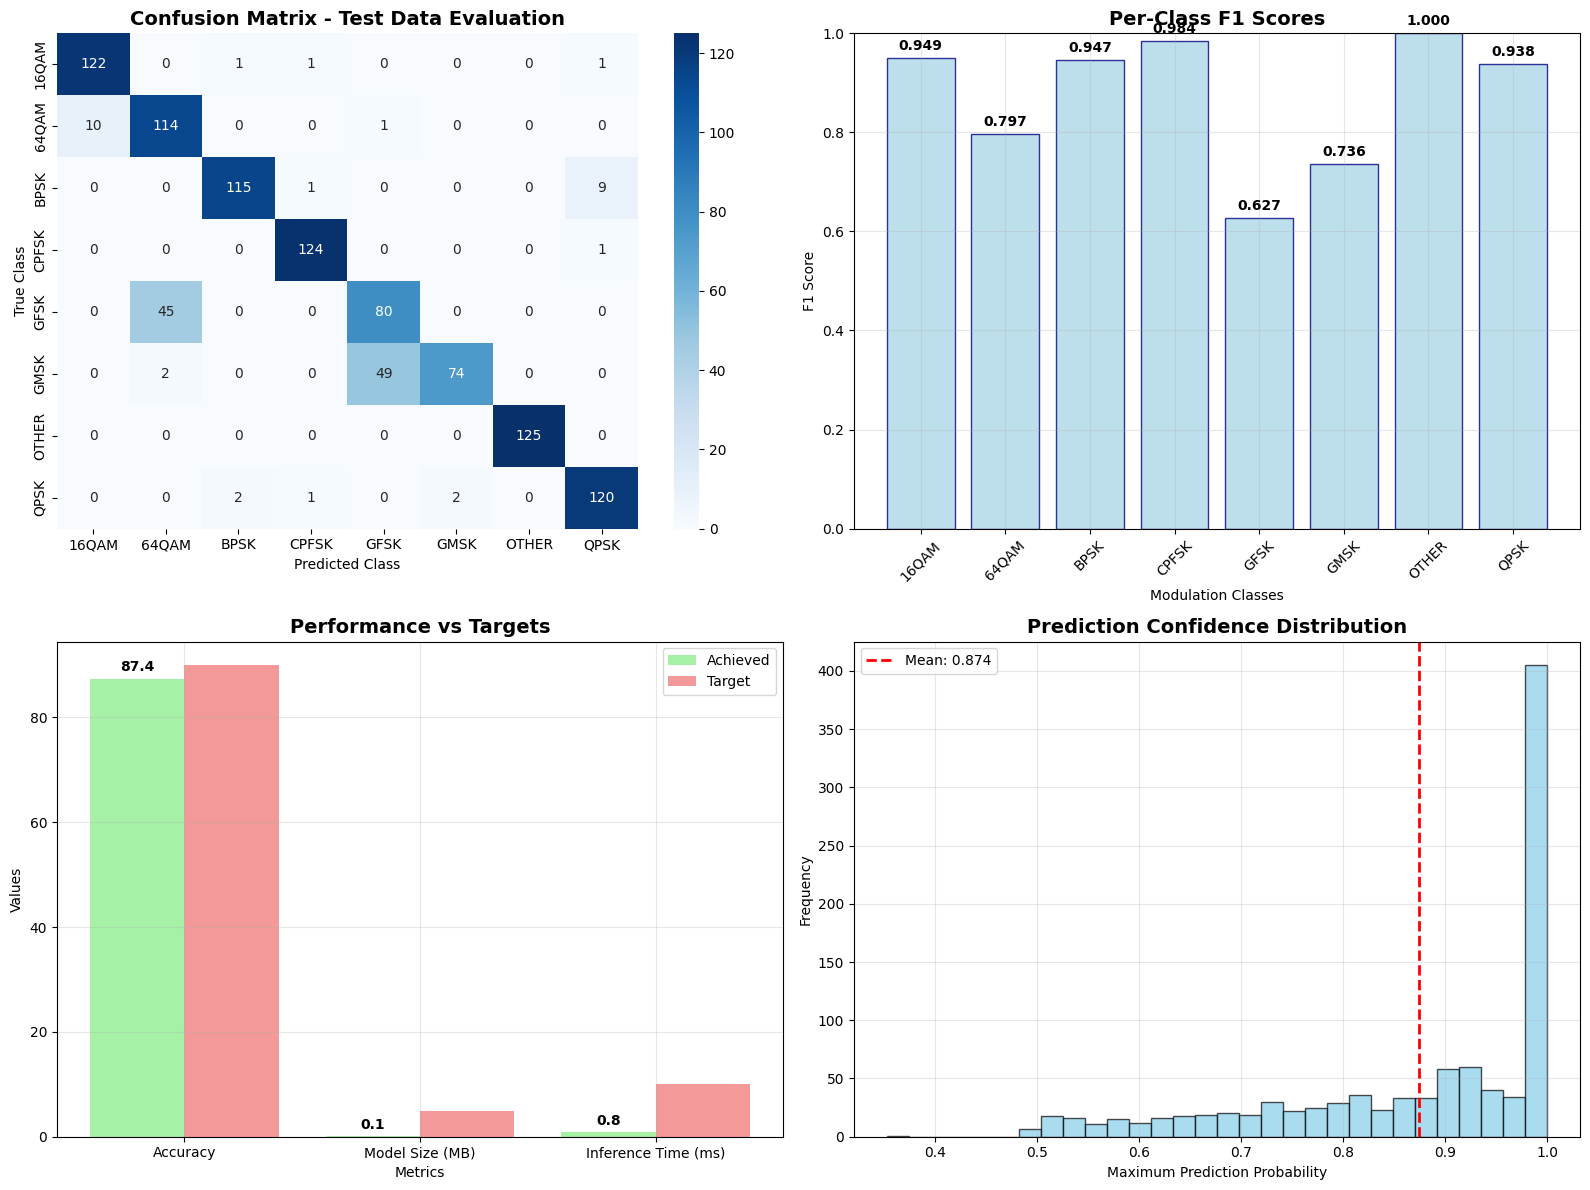


🎯 PERFORMANCE ANALYSIS & RECOMMENDATIONS
📈 TARGET ACHIEVEMENT STATUS:
----------------------------------------
   • Accuracy Target (≥90%): 87.40% - ⚠️ CLOSE
   • Model Size Target (≤5MB): 0.09MB - ✅ ACHIEVED
   • Speed Target (≤10ms): 0.83ms - ✅ ACHIEVED

 CLASS PERFORMANCE ANALYSIS:
----------------------------------------
   • Average F1 Score: 0.872 ± 0.127
   • Performance Range: 0.627 - 1.000
   • Classes needing attention: 64QAM, GFSK, GMSK

 PREDICTION CONFIDENCE ANALYSIS:
----------------------------------------
   • Average Confidence: 0.874
   • Low Confidence Predictions (<0.8): 270/1000 (27.0%)

 RECOMMENDATIONS:
----------------------------------------
    TO IMPROVE ACCURACY:
     • Increase model capacity (alpha parameter)
     • Add more diverse data augmentation
     • Try ensemble methods
     • Fine-tune on problematic classes
    FOR POOR-PERFORMING CLASSES:
     • Apply class-specific data augmentation
     • Collect more samples for these classes
     • Use foca

In [ ]:
class TestDataEvaluator:
    """
    Comprehensive evaluation using separate test dataset.
    Loads test data from the same folder structure as training data.
    """

    def __init__(self, test_data_path):
        self.test_data_path = test_data_path
        self.test_classes = None
        self.X_test = None
        self.y_test = None
        self.class_names = None

    def load_test_data(self):
        """Load test data from the specified path with same structure as training data."""
        print("🔄 Loading test data from separate test dataset...")
        print(f"Test data path: {self.test_data_path}")

        if not os.path.exists(self.test_data_path):
            print(f"❌ Test data path not found: {self.test_data_path}")
            return False

        # Get available classes from test data folders
        self.test_classes = [d for d in os.listdir(self.test_data_path)
                            if os.path.isdir(os.path.join(self.test_data_path, d))]
        self.test_classes.sort()  # Ensure consistent ordering

        print(f"📁 Found test classes: {self.test_classes}")

        samples = []
        labels = []
        sample_names = []
        class_distribution = {}

        for class_idx, class_name in enumerate(self.test_classes):
            class_path = os.path.join(self.test_data_path, class_name)
            npy_files = glob.glob(os.path.join(class_path, '*.npy'))

            class_samples = 0
            for npy_file in npy_files:
                try:
                    # Load I/Q samples
                    iq_samples = np.load(npy_file)

                    # Convert to real/imaginary format
                    real = np.real(iq_samples)
                    imag = np.imag(iq_samples)

                    # Interleave real and imaginary parts
                    iq_interleaved = np.ravel(np.column_stack((real, imag)))

                    # Take first 1568 samples (28x28x2 = 1568)
                    iq_trimmed = iq_interleaved[:1568]

                    # Reshape to (28, 28, 2)
                    iq_reshaped = iq_trimmed.reshape(28, 28, 2)

                    samples.append(iq_reshaped)

                    # Create one-hot label
                    label = np.zeros(len(self.test_classes))
                    label[class_idx] = 1.0
                    labels.append(label)

                    sample_names.append(os.path.basename(npy_file))
                    class_samples += 1

                except Exception as e:
                    print(f"⚠️ Error loading {npy_file}: {str(e)}")
                    continue

            class_distribution[class_name] = class_samples
            print(f"  📊 {class_name}: {class_samples} samples")

        self.X_test = np.array(samples, dtype=np.float32)
        self.y_test = np.array(labels, dtype=np.float32)
        self.class_names = self.test_classes

        print(f"\n✅ Test data loaded successfully!")
        print(f"   • Total test samples: {len(self.X_test)}")
        print(f"   • Input shape: {self.X_test.shape}")
        print(f"   • Label shape: {self.y_test.shape}")
        print(f"   • Number of classes: {len(self.test_classes)}")

        return True

    def evaluate_model(self, model, detailed_analysis=True):
        """
        Comprehensive model evaluation on test data.
        """
        if self.X_test is None:
            print("❌ No test data loaded. Please run load_test_data() first.")
            return None

        print("\n🔍 EVALUATING MODEL ON SEPARATE TEST DATASET")
        print("=" * 60)

        # Measure inference time
        print("⏱️ Measuring inference performance...")
        start_time = time.time()
        predictions = model.predict(self.X_test, verbose=1)
        total_inference_time = time.time() - start_time
        avg_inference_time_ms = (total_inference_time / len(self.X_test)) * 1000

        # Calculate predictions and ground truth
        y_pred = np.argmax(predictions, axis=1)
        y_true = np.argmax(self.y_test, axis=1)

        # Overall accuracy
        accuracy = np.mean(y_pred == y_true)

        # Model size
        model_size_mb = (model.count_params() * 4) / (1024 * 1024)

        print(f"\n OVERALL PERFORMANCE METRICS:")
        print("-" * 40)
        print(f"   • Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"   • Model Size: {model_size_mb:.2f} MB")
        print(f"   • Total Inference Time: {total_inference_time:.2f} seconds")
        print(f"   • Average Inference Time: {avg_inference_time_ms:.2f} ms per sample")
        print(f"   • Throughput: {len(self.X_test)/total_inference_time:.1f} samples/second")
        print(f"   • Total Parameters: {model.count_params():,}")

        # Detailed per-class analysis
        if detailed_analysis:
            print(f"\n DETAILED CLASSIFICATION REPORT:")
            print("-" * 50)
            print(classification_report(y_true, y_pred, target_names=self.class_names, digits=4))

            # Per-class metrics
            precision, recall, f1, support = precision_recall_fscore_support(
                y_true, y_pred, average=None
            )

            print(f"\n PER-CLASS PERFORMANCE SUMMARY:")
            print("-" * 50)
            for i, class_name in enumerate(self.class_names):
                print(f"   {class_name:>8s}: Precision={precision[i]:.3f}, "
                      f"Recall={recall[i]:.3f}, F1={f1[i]:.3f}, Support={support[i]}")

            # Identify best and worst performing classes
            best_class_idx = np.argmax(f1)
            worst_class_idx = np.argmin(f1)

            print(f"\n Best Performing Class: {self.class_names[best_class_idx]} (F1={f1[best_class_idx]:.3f})")
            print(f" Needs Attention: {self.class_names[worst_class_idx]} (F1={f1[worst_class_idx]:.3f})")

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        results = {
            'accuracy': accuracy,
            'model_size_mb': model_size_mb,
            'inference_time_ms': avg_inference_time_ms,
            'total_inference_time': total_inference_time,
            'throughput': len(self.X_test)/total_inference_time,
            'confusion_matrix': cm,
            'predictions': predictions,
            'y_true': y_true,
            'y_pred': y_pred,
            'precision': precision if detailed_analysis else None,
            'recall': recall if detailed_analysis else None,
            'f1_score': f1 if detailed_analysis else None,
            'support': support if detailed_analysis else None,
            'class_names': self.class_names
        }

        return results

    def create_visualization(self, results, save_plots=True):
        """
        Create comprehensive visualizations of test results.
        """
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Confusion Matrix
        sns.heatmap(results['confusion_matrix'],
                   xticklabels=results['class_names'],
                   yticklabels=results['class_names'],
                   annot=True, fmt='d',
                   cmap='Blues',
                   ax=axes[0,0])
        axes[0,0].set_title('Confusion Matrix - Test Data Evaluation', fontsize=14, fontweight='bold')
        axes[0,0].set_xlabel('Predicted Class')
        axes[0,0].set_ylabel('True Class')

        # 2. Per-class F1 Scores
        if results['f1_score'] is not None:
            bars = axes[0,1].bar(results['class_names'], results['f1_score'],
                               color='lightblue', alpha=0.8, edgecolor='navy')
            axes[0,1].set_title('Per-Class F1 Scores', fontsize=14, fontweight='bold')
            axes[0,1].set_xlabel('Modulation Classes')
            axes[0,1].set_ylabel('F1 Score')
            axes[0,1].set_ylim(0, 1)
            axes[0,1].tick_params(axis='x', rotation=45)
            axes[0,1].grid(True, alpha=0.3)

            # Add value labels on bars
            for bar, score in zip(bars, results['f1_score']):
                height = bar.get_height()
                axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

        # 3. Performance Metrics Comparison
        metrics = ['Accuracy', 'Model Size (MB)', 'Inference Time (ms)']
        values = [results['accuracy']*100, results['model_size_mb'], results['inference_time_ms']]
        targets = [90, 5, 10]  # Target values

        x_pos = np.arange(len(metrics))
        bars1 = axes[1,0].bar(x_pos - 0.2, values, 0.4, label='Achieved', color='lightgreen', alpha=0.8)
        bars2 = axes[1,0].bar(x_pos + 0.2, targets, 0.4, label='Target', color='lightcoral', alpha=0.8)

        axes[1,0].set_title('Performance vs Targets', fontsize=14, fontweight='bold')
        axes[1,0].set_xlabel('Metrics')
        axes[1,0].set_ylabel('Values')
        axes[1,0].set_xticks(x_pos)
        axes[1,0].set_xticklabels(metrics)
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

        # Add value labels
        for bar, value in zip(bars1, values):
            height = bar.get_height()
            axes[1,0].text(bar.get_x() + bar.get_width()/2., height + max(values)*0.01,
                          f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

        # 4. Prediction Confidence Distribution
        max_probs = np.max(results['predictions'], axis=1)
        axes[1,1].hist(max_probs, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1,1].axvline(np.mean(max_probs), color='red', linestyle='--', linewidth=2,
                         label=f'Mean: {np.mean(max_probs):.3f}')
        axes[1,1].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
        axes[1,1].set_xlabel('Maximum Prediction Probability')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()

        if save_plots:
            plt.savefig('test_evaluation_results.png', dpi=300, bbox_inches='tight')
            print("📊 Visualization saved as 'test_evaluation_results.png'")

        plt.show()

        return fig

    def performance_analysis(self, results):
        """
        Provide detailed performance analysis and recommendations.
        """
        print("\n🎯 PERFORMANCE ANALYSIS & RECOMMENDATIONS")
        print("=" * 60)

        # Target achievement analysis
        accuracy_target = 0.90
        size_target = 5.0  # MB
        speed_target = 10.0  # ms

        print(f"📈 TARGET ACHIEVEMENT STATUS:")
        print("-" * 40)

        accuracy_status = "✅ ACHIEVED" if results['accuracy'] >= accuracy_target else "⚠️ CLOSE" if results['accuracy'] >= 0.85 else "❌ NEEDS IMPROVEMENT"
        size_status = "✅ ACHIEVED" if results['model_size_mb'] <= size_target else "❌ EXCEEDED"
        speed_status = "✅ ACHIEVED" if results['inference_time_ms'] <= speed_target else "❌ EXCEEDED"

        print(f"   • Accuracy Target (≥90%): {results['accuracy']*100:.2f}% - {accuracy_status}")
        print(f"   • Model Size Target (≤5MB): {results['model_size_mb']:.2f}MB - {size_status}")
        print(f"   • Speed Target (≤10ms): {results['inference_time_ms']:.2f}ms - {speed_status}")

        # Class-wise performance analysis
        if results['f1_score'] is not None:
            print(f"\n CLASS PERFORMANCE ANALYSIS:")
            print("-" * 40)

            avg_f1 = np.mean(results['f1_score'])
            std_f1 = np.std(results['f1_score'])

            print(f"   • Average F1 Score: {avg_f1:.3f} ± {std_f1:.3f}")
            print(f"   • Performance Range: {np.min(results['f1_score']):.3f} - {np.max(results['f1_score']):.3f}")

            # Identify problematic classes
            poor_classes = [results['class_names'][i] for i, f1 in enumerate(results['f1_score']) if f1 < 0.8]
            if poor_classes:
                print(f"   • Classes needing attention: {', '.join(poor_classes)}")
            else:
                print(f"   • All classes performing well (F1 > 0.8)")

        # Confidence analysis
        confidence_scores = np.max(results['predictions'], axis=1)
        low_confidence = np.sum(confidence_scores < 0.8)

        print(f"\n PREDICTION CONFIDENCE ANALYSIS:")
        print("-" * 40)
        print(f"   • Average Confidence: {np.mean(confidence_scores):.3f}")
        print(f"   • Low Confidence Predictions (<0.8): {low_confidence}/{len(confidence_scores)} ({low_confidence/len(confidence_scores)*100:.1f}%)")

        # Recommendations
        print(f"\n RECOMMENDATIONS:")
        print("-" * 40)

        if results['accuracy'] < 0.90:
            print("    TO IMPROVE ACCURACY:")
            print("     • Increase model capacity (alpha parameter)")
            print("     • Add more diverse data augmentation")
            print("     • Try ensemble methods")
            print("     • Fine-tune on problematic classes")

        if results['model_size_mb'] > 5.0:
            print("    TO REDUCE MODEL SIZE:")
            print("     • Reduce alpha parameter (width multiplier)")
            print("     • Apply model pruning")
            print("     • Use more aggressive quantization")

        if results['inference_time_ms'] > 10.0:
            print("    TO IMPROVE SPEED:")
            print("     • Reduce model complexity")
            print("     • Optimize batch size for your hardware")
            print("     • Consider TensorFlow Lite with quantization")

        if poor_classes:
            print("    FOR POOR-PERFORMING CLASSES:")
            print("     • Apply class-specific data augmentation")
            print("     • Collect more samples for these classes")
            print("     • Use focal loss or class weighting")

# Set up test data path (Update this to your actual test data path)
TEST_DATA_PATH = r"C:\Users\Jehan_140826\Downloads\rfsc-dataset\Dataset_Deep_Radio\Dataset_Deep_Radio\testing_data"

# Alternative paths if the above doesn't work
alternative_paths = [
    "/content/drive/MyDrive/rfsc-dataset/Dataset_Deep_Radio/Dataset_Deep_Radio/testing_data",
    "testing_data",  # If in current directory
    "./testing_data"
]

# Try to find the correct path
test_path_found = None
if os.path.exists(TEST_DATA_PATH):
    test_path_found = TEST_DATA_PATH
else:
    print(f"Primary test path not found: {TEST_DATA_PATH}")
    print("Trying alternative paths...")
    for alt_path in alternative_paths:
        if os.path.exists(alt_path):
            test_path_found = alt_path
            print(f"Found test data at: {alt_path}")
            break

if test_path_found:
    print(f"🔍 COMPREHENSIVE TEST DATA EVALUATION")
    print("=" * 60)
    print(f"Using test data from: {test_path_found}")

    # Initialize evaluator
    evaluator = TestDataEvaluator(test_path_found)

    # Load test data
    if evaluator.load_test_data():
        # Ensure model is available
        if 'enhanced_model' in globals():
            print(f"\nUsing optimized model for evaluation...")
            test_results = evaluator.evaluate_model(enhanced_model, detailed_analysis=True)
        elif 'enhanced_model' in globals():
            print(f"\nUsing Model 4 for evaluation...")
            test_results = evaluator.evaluate_model(enhanced_model, detailed_analysis=True)
        else:
            print(" No trained model found. Please train a model first.")
            test_results = None

        if test_results:
            # Create visualizations
            evaluator.create_visualization(test_results, save_plots=True)

            # Performance analysis
            evaluator.performance_analysis(test_results)

            # Summary
            print(f"\n🎉 TEST EVALUATION COMPLETE!")
            print("=" * 60)
            print(f" Evaluated on {len(evaluator.X_test)} test samples")
            print(f" Test accuracy: {test_results['accuracy']*100:.2f}%")
            print(f" Model size: {test_results['model_size_mb']:.2f} MB")
            print(f" Inference speed: {test_results['inference_time_ms']:.2f} ms/sample")
            print("=" * 60)

        else:
            print(" Test evaluation failed.")

    else:
        print(" Failed to load test data.")

else:
    print(" Test data path not found!")


In [ ]:
model_path = "/content/best_model.keras" # Define the path to save the model
enhanced_model.save(model_path)
print(f"Best model saved to {model_path}")

Best model saved to /content/best_model.keras


In [ ]:
import pickle

# Define paths for saving
h5_model_path = "/content/best_model.h5"
pickle_model_path = "/content/best_model.pkl"

# Save as HDF5
enhanced_model.save(h5_model_path)
print(f"Model saved as HDF5 to {h5_model_path}")

# Save as Pickle
with open(pickle_model_path, 'wb') as f:
    pickle.dump(enhanced_model, f)
print(f"Model saved as Pickle to {pickle_model_path}")

Model saved as HDF5 to /content/best_model.h5
Model saved as Pickle to /content/best_model.pkl


In [ ]:
Print("stop")

In [ ]:
Print("stop")

# **DONT RUN‼️**

Run 1: batch_size=32, lr=5e-05, weight_decay=0.0001, beta1=0.9, beta2=0.99
Epoch 1/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1505 - loss: 2.1478
Epoch 1: val_loss improved from inf to 2.11423, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.1506 - loss: 2.1475 - val_accuracy: 0.1383 - val_loss: 2.1142 - learning_rate: 5.0000e-05
Epoch 2/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2719 - loss: 1.9139
Epoch 2: val_loss improved from 2.11423 to 1.98201, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.2719 - loss: 1.9138 - val_accuracy: 0.2333 - val_loss: 1.9820 - learning_rate: 5.0000e-05
Epoch 3/60
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3047 - loss: 1.7873
Epoch 3: val_loss improved from 1.98201 to 1.76197, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.3048 - loss: 1.7871 - val_accuracy:

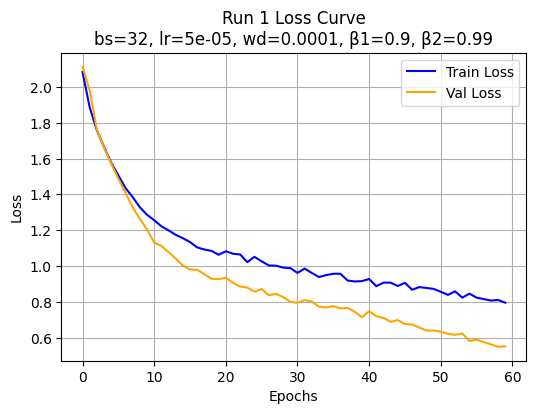

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Test Accuracy: 0.8250, F1-score: 0.8218
Run 2: batch_size=32, lr=5e-05, weight_decay=0.0002, beta1=0.9, beta2=0.99
Epoch 1/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1858 - loss: 2.0526
Epoch 1: val_loss improved from inf to 2.17369, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.1859 - loss: 2.0526 - val_accuracy: 0.0933 - val_loss: 2.1737 - learning_rate: 5.0000e-05
Epoch 2/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2580 - loss: 1.9710
Epoch 2: val_loss did not improve from 2.17369
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.2581 - loss: 1.9709 - val_accuracy: 0.0933 - val_loss: 2.2004 - learning_rate: 5.0000e-05
Epoch 3/60
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2954 - loss: 1.8890
Epoch 3: val_loss improved from 2.17369 to 2.04098, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.29

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Test Accuracy: 0.6083, F1-score: 0.5771
Run 3: batch_size=32, lr=5e-05, weight_decay=0.0005, beta1=0.9, beta2=0.99
Epoch 1/60
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2095 - loss: 1.9622
Epoch 1: val_loss improved from inf to 2.19023, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.2097 - loss: 1.9619 - val_accuracy: 0.1383 - val_loss: 2.1902 - learning_rate: 5.0000e-05
Epoch 2/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2798 - loss: 1.8182
Epoch 2: val_loss did not improve from 2.19023
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.2799 - loss: 1.8181 - val_accuracy: 0.0950 - val_loss: 2.2034 - learning_rate: 5.0000e-05
Epoch 3/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3398 - loss: 1.6946
Epoch 3: val_loss improved from 2.19023 to 1.86571, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.33

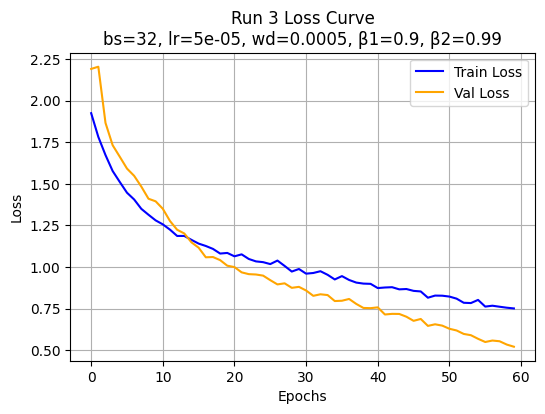

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Test Accuracy: 0.8300, F1-score: 0.8273
Run 4: batch_size=32, lr=0.0001, weight_decay=0.0001, beta1=0.9, beta2=0.99
Epoch 1/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.1279 - loss: 2.1078
Epoch 1: val_loss improved from inf to 2.11527, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.1281 - loss: 2.1075 - val_accuracy: 0.0933 - val_loss: 2.1153 - learning_rate: 1.0000e-04
Epoch 2/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2996 - loss: 1.8617
Epoch 2: val_loss improved from 2.11527 to 1.98494, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.2997 - loss: 1.8615 - val_accuracy: 0.1167 - val_loss: 1.9849 - learning_rate: 1.0000e-04
Epoch 3/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3729 - loss: 1.6402
Epoch 3: val_loss improved from 1.98494 to 1.62425, saving model to enhanced_best_model.keras
225/225 ━━━

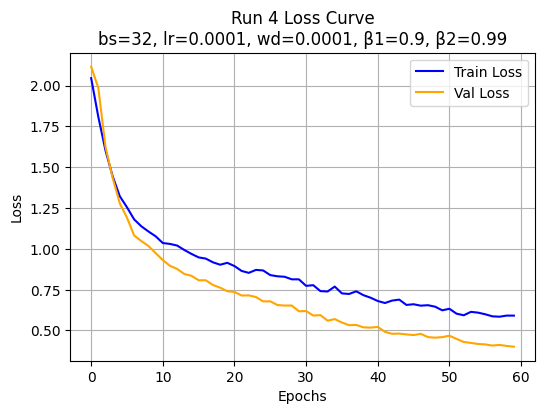

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Test Accuracy: 0.8683, F1-score: 0.8650
Run 5: batch_size=32, lr=0.0001, weight_decay=0.0002, beta1=0.9, beta2=0.99
Epoch 1/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2078 - loss: 2.0238
Epoch 1: val_loss improved from inf to 2.11369, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step - accuracy: 0.2080 - loss: 2.0234 - val_accuracy: 0.1433 - val_loss: 2.1137 - learning_rate: 1.0000e-04
Epoch 2/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3549 - loss: 1.6937
Epoch 2: val_loss improved from 2.11369 to 1.90265, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.3550 - loss: 1.6935 - val_accuracy: 0.2967 - val_loss: 1.9027 - learning_rate: 1.0000e-04
Epoch 3/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4126 - loss: 1.5132
Epoch 3: val_loss improved from 1.90265 to 1.44620, saving model to enhanced_best_model.keras
225/225 ━━━

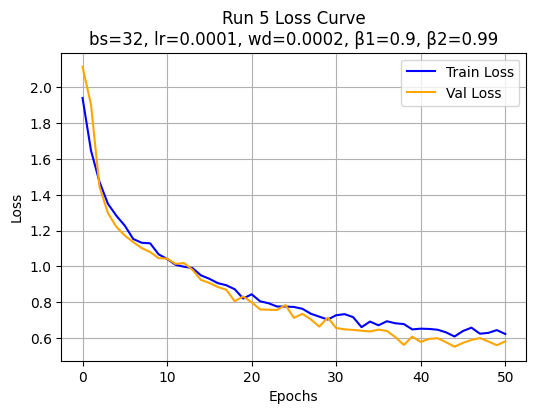

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Test Accuracy: 0.7733, F1-score: 0.7658
Run 6: batch_size=32, lr=0.0001, weight_decay=0.0005, beta1=0.9, beta2=0.99
Epoch 1/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.1729 - loss: 2.0306
Epoch 1: val_loss improved from inf to 2.09482, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.1730 - loss: 2.0305 - val_accuracy: 0.1217 - val_loss: 2.0948 - learning_rate: 1.0000e-04
Epoch 2/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2628 - loss: 1.8970
Epoch 2: val_loss improved from 2.09482 to 2.05469, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - accuracy: 0.2628 - loss: 1.8969 - val_accuracy: 0.1267 - val_loss: 2.0547 - learning_rate: 1.0000e-04
Epoch 3/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3087 - loss: 1.7647
Epoch 3: val_loss improved from 2.05469 to 1.86164, saving model to enhanced_best_model.keras
225/225 ━━━

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Test Accuracy: 0.8333, F1-score: 0.8277
Run 7: batch_size=32, lr=0.0002, weight_decay=0.0001, beta1=0.9, beta2=0.99
Epoch 1/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2151 - loss: 1.9883
Epoch 1: val_loss improved from inf to 2.20534, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 68ms/step - accuracy: 0.2155 - loss: 1.9876 - val_accuracy: 0.0950 - val_loss: 2.2053 - learning_rate: 2.0000e-04
Epoch 2/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4367 - loss: 1.4719
Epoch 2: val_loss did not improve from 2.20534
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.4368 - loss: 1.4716 - val_accuracy: 0.2033 - val_loss: 2.4696 - learning_rate: 2.0000e-04
Epoch 3/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5174 - loss: 1.2251
Epoch 3: val_loss improved from 2.20534 to 1.59665, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.5

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Test Accuracy: 0.8417, F1-score: 0.8365
Run 8: batch_size=32, lr=0.0002, weight_decay=0.0002, beta1=0.9, beta2=0.99
Epoch 1/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2067 - loss: 1.9778
Epoch 1: val_loss improved from inf to 2.17445, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step - accuracy: 0.2070 - loss: 1.9773 - val_accuracy: 0.1400 - val_loss: 2.1745 - learning_rate: 2.0000e-04
Epoch 2/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3832 - loss: 1.5569
Epoch 2: val_loss improved from 2.17445 to 1.98785, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.3833 - loss: 1.5566 - val_accuracy: 0.1933 - val_loss: 1.9878 - learning_rate: 2.0000e-04
Epoch 3/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4465 - loss: 1.3655
Epoch 3: val_loss improved from 1.98785 to 1.28235, saving model to enhanced_best_model.keras
225/225 ━━━

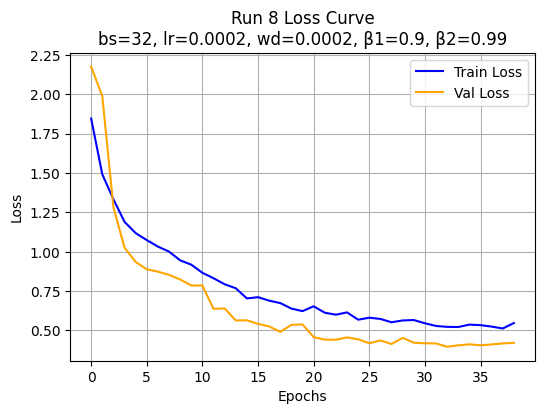

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Test Accuracy: 0.8217, F1-score: 0.8160
Run 9: batch_size=32, lr=0.0002, weight_decay=0.0005, beta1=0.9, beta2=0.99
Epoch 1/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2153 - loss: 1.9755
Epoch 1: val_loss improved from inf to 2.24060, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - accuracy: 0.2155 - loss: 1.9750 - val_accuracy: 0.1233 - val_loss: 2.2406 - learning_rate: 2.0000e-04
Epoch 2/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3576 - loss: 1.6479
Epoch 2: val_loss did not improve from 2.24060
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.3578 - loss: 1.6475 - val_accuracy: 0.0950 - val_loss: 2.5885 - learning_rate: 2.0000e-04
Epoch 3/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4413 - loss: 1.4149
Epoch 3: val_loss improved from 2.24060 to 1.56491, saving model to enhanced_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.4

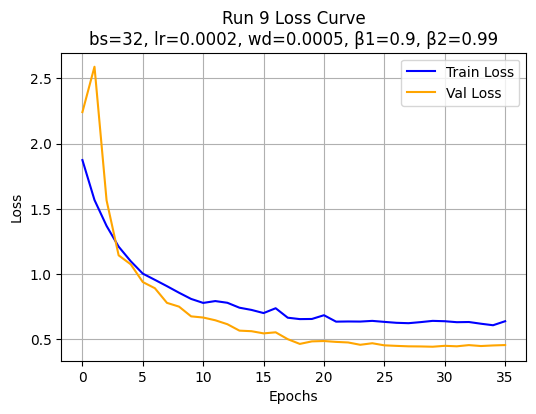

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Test Accuracy: 0.8317, F1-score: 0.8275

All results sorted by accuracy:
   batch_size       lr  weight_decay  beta_1  beta_2  accuracy  f1_score
3          32  0.00010        0.0001     0.9    0.99  0.868333  0.864983
6          32  0.00020        0.0001     0.9    0.99  0.841667  0.836520
5          32  0.00010        0.0005     0.9    0.99  0.833333  0.827663
8          32  0.00020        0.0005     0.9    0.99  0.831667  0.827481
2          32  0.00005        0.0005     0.9    0.99  0.830000  0.827335
0          32  0.00005        0.0001     0.9    0.99  0.825000  0.821820
7          32  0.00020        0.0002     0.9    0.99  0.821667  0.815963
4          32  0.00010        0.0002     0.9    0.99  0.773333  0.765844
1          32  0.00005        0.0002     0.9    0.99  0.608333  0.577096


In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

# ===== HYPERPARAMETER GRID =====
batch_sizes = [32]
learning_rates = [5e-5, 1e-4, 2e-4]
weight_decays = [1e-4, 2e-4, 5e-4]
beta_1_list = [0.9]
beta_2_list = [0.99]

# Fixed hyperparameters
epochs = 60
patience_es = 6
patience_lr = 3
min_delta = 5e-4
checkpoint_path = "enhanced_best_model.keras"
dropout_rates = [0.1, 0.1, 0.15, 0.2, 0.25, 0.5]
alpha = 0.6
snr_range = (5, 25)
augmentation_factor = 2

results = []

# ===== MANUAL GRID SEARCH WITH LOSS PLOTS =====
for idx, (batch_size, lr, wd, b1, b2) in enumerate(itertools.product(batch_sizes, learning_rates, weight_decays, beta_1_list, beta_2_list)):
    print("="*60)
    print(f"Run {idx+1}: batch_size={batch_size}, lr={lr}, weight_decay={wd}, beta1={b1}, beta2={b2}")

    # Create model
    model = EnhancedOptimizedCNN(input_shape=(28,28,2), num_classes=num_classes, alpha=alpha)
    enhanced_model = model.create_model(dropout_rates)

    # Create augmentor
    augmentor = AdvancedRFAugmentation(snr_range=snr_range, augmentation_factor=augmentation_factor)

    # Create training pipeline
    pipeline = ClassWeightedTrainingPipeline(enhanced_model, augmentor, classes)

    # Train model
    history = pipeline.train_enhanced_model(
        X_train=Xtrain,
        y_train=Ytrain,
        Xtest=Xtest,
        Ytest=Ytest,
        epochs=epochs,
        batch_size=batch_size,
        lr=lr,
        weight_decay=wd,
        beta_1=b1,
        beta_2=b2,
        patience_es=patience_es,
        patience_lr=patience_lr,
        min_delta=min_delta,
        checkpoint_path=checkpoint_path
    )

    # Plot loss curve for this run
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
    plt.title(f"Run {idx+1} Loss Curve\nbs={batch_size}, lr={lr}, wd={wd}, β1={b1}, β2={b2}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate on test set
    y_pred_probs = enhanced_model.predict(Xtest)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(Ytest, axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Test Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

    results.append({
        'batch_size': batch_size,
        'lr': lr,
        'weight_decay': wd,
        'beta_1': b1,
        'beta_2': b2,
        'accuracy': acc,
        'f1_score': f1
    })

# ===== Convert results to DataFrame for analysis =====
results_df = pd.DataFrame(results)
print("\nAll results sorted by accuracy:")
print(results_df.sort_values(by='accuracy', ascending=False))


Run 1: batch_size=16, lr=5e-05, weight_decay=0.0001, beta1=0.85, beta2=0.98
Epoch 1/60
444/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2012 - loss: 2.0389
Epoch 1: val_loss improved from inf to 2.18549, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.2022 - loss: 2.0372 - val_accuracy: 0.2183 - val_loss: 2.1855 - learning_rate: 5.0000e-05
Epoch 2/60
446/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3599 - loss: 1.6993
Epoch 2: val_loss improved from 2.18549 to 1.61762, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3600 - loss: 1.6989 - val_accuracy: 0.3467 - val_loss: 1.6176 - learning_rate: 5.0000e-05
Epoch 3/60
446/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3971 - loss: 1.5393
Epoch 3: val_loss improved from 1.61762 to 1.51655, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3971 - loss: 1.5391 - val_accuracy: 0.330

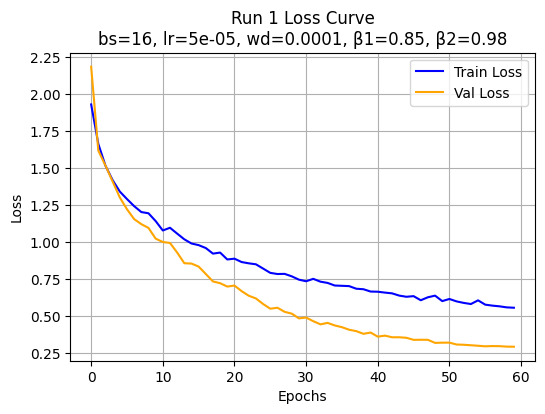

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
Test Accuracy: 0.8783, F1-score: 0.8732
Run 2: batch_size=16, lr=5e-05, weight_decay=0.0001, beta1=0.85, beta2=0.99
Epoch 1/60
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2015 - loss: 2.0063
Epoch 1: val_loss improved from inf to 2.30662, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.2017 - loss: 2.0058 - val_accuracy: 0.1117 - val_loss: 2.3066 - learning_rate: 5.0000e-05
Epoch 2/60
445/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3503 - loss: 1.6817
Epoch 2: val_loss improved from 2.30662 to 1.65482, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3503 - loss: 1.6815 - val_accuracy: 0.2900 - val_loss: 1.6548 - learning_rate: 5.0000e-05
Epoch 3/60
444/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4012 - loss: 1.5585
Epoch 3: val_loss improved from 1.65482 to 1.55393, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━

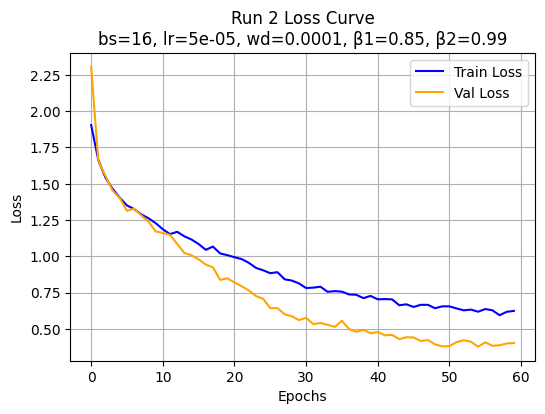

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
Test Accuracy: 0.8250, F1-score: 0.8177
Run 3: batch_size=16, lr=5e-05, weight_decay=0.0001, beta1=0.85, beta2=0.999
Epoch 1/60
440/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1980 - loss: 2.0140
Epoch 1: val_loss improved from inf to 2.18508, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.1995 - loss: 2.0109 - val_accuracy: 0.1267 - val_loss: 2.1851 - learning_rate: 5.0000e-05
Epoch 2/60
444/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3230 - loss: 1.6939
Epoch 2: val_loss improved from 2.18508 to 1.66436, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3234 - loss: 1.6930 - val_accuracy: 0.1983 - val_loss: 1.6644 - learning_rate: 5.0000e-05
Epoch 3/60
442/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3811 - loss: 1.5482
Epoch 3: val_loss improved from 1.66436 to 1.53211, saving model to enhanced_best_model.keras
450/450 ━━━━━━━

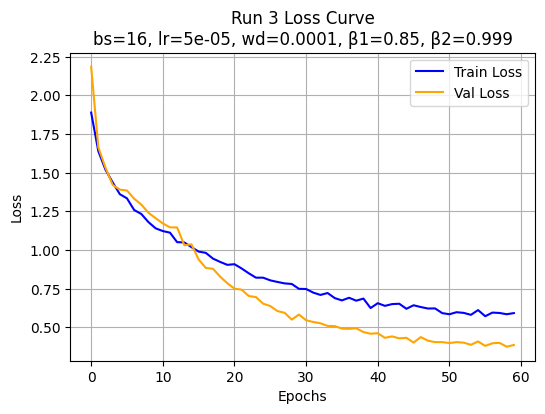

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
Test Accuracy: 0.8333, F1-score: 0.8312
Run 4: batch_size=16, lr=5e-05, weight_decay=0.0001, beta1=0.9, beta2=0.98
Epoch 1/60
443/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1916 - loss: 2.0120
Epoch 1: val_loss improved from inf to 2.30787, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.1927 - loss: 2.0105 - val_accuracy: 0.2733 - val_loss: 2.3079 - learning_rate: 5.0000e-05
Epoch 2/60
444/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3673 - loss: 1.7067
Epoch 2: val_loss improved from 2.30787 to 1.65216, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3674 - loss: 1.7059 - val_accuracy: 0.3067 - val_loss: 1.6522 - learning_rate: 5.0000e-05
Epoch 3/60
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3970 - loss: 1.5274
Epoch 3: val_loss improved from 1.65216 to 1.53316, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━

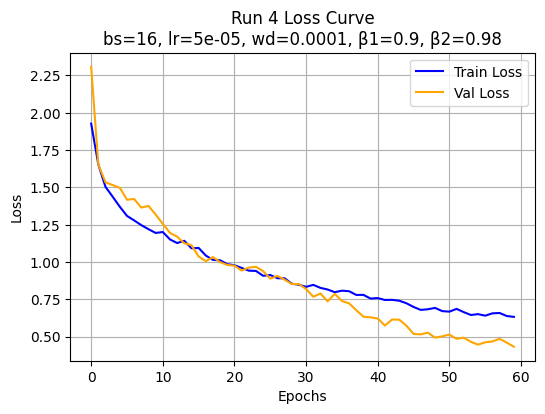

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step
Test Accuracy: 0.8067, F1-score: 0.8005
Run 5: batch_size=16, lr=5e-05, weight_decay=0.0001, beta1=0.9, beta2=0.99
Epoch 1/60
446/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2381 - loss: 1.9431
Epoch 1: val_loss improved from inf to 2.41838, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.2385 - loss: 1.9420 - val_accuracy: 0.1267 - val_loss: 2.4184 - learning_rate: 5.0000e-05
Epoch 2/60
444/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3619 - loss: 1.6325
Epoch 2: val_loss improved from 2.41838 to 1.78271, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3621 - loss: 1.6317 - val_accuracy: 0.2533 - val_loss: 1.7827 - learning_rate: 5.0000e-05
Epoch 3/60
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4109 - loss: 1.4673
Epoch 3: val_loss improved from 1.78271 to 1.67278, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━

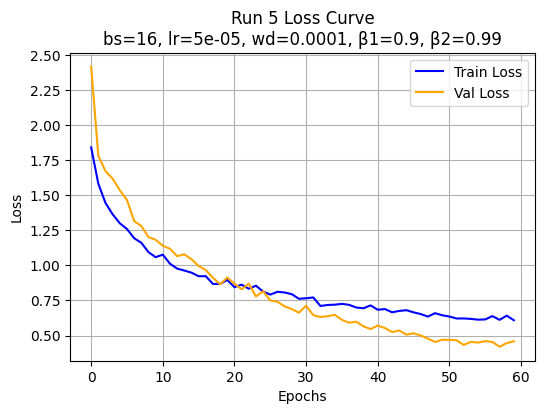

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
Test Accuracy: 0.8450, F1-score: 0.8435
Run 6: batch_size=16, lr=5e-05, weight_decay=0.0001, beta1=0.9, beta2=0.999
Epoch 1/60
445/450 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2312 - loss: 1.9358
Epoch 1: val_loss improved from inf to 2.09271, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.2319 - loss: 1.9346 - val_accuracy: 0.1267 - val_loss: 2.0927 - learning_rate: 5.0000e-05
Epoch 2/60
446/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3607 - loss: 1.6548
Epoch 2: val_loss improved from 2.09271 to 1.63572, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3607 - loss: 1.6547 - val_accuracy: 0.3000 - val_loss: 1.6357 - learning_rate: 5.0000e-05
Epoch 3/60
444/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3971 - loss: 1.5593
Epoch 3: val_loss improved from 1.63572 to 1.50502, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━

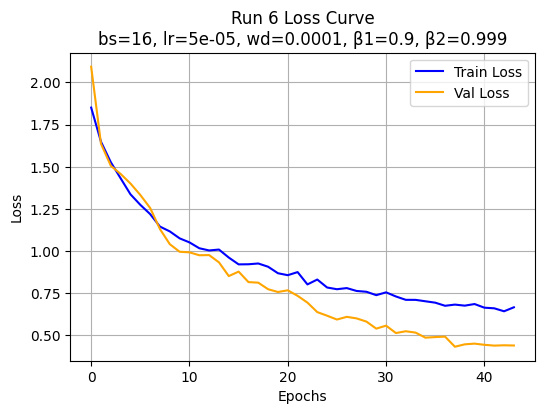

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
Test Accuracy: 0.8383, F1-score: 0.8358
Run 7: batch_size=16, lr=5e-05, weight_decay=0.0002, beta1=0.85, beta2=0.98
Epoch 1/60
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1954 - loss: 2.0105
Epoch 1: val_loss improved from inf to 2.21440, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.1957 - loss: 2.0097 - val_accuracy: 0.2367 - val_loss: 2.2144 - learning_rate: 5.0000e-05
Epoch 2/60
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3328 - loss: 1.6647
Epoch 2: val_loss improved from 2.21440 to 1.70324, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3329 - loss: 1.6645 - val_accuracy: 0.3317 - val_loss: 1.7032 - learning_rate: 5.0000e-05
Epoch 3/60
444/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3774 - loss: 1.5058
Epoch 3: val_loss improved from 1.70324 to 1.58940, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
Test Accuracy: 0.8283, F1-score: 0.8226
Run 8: batch_size=16, lr=5e-05, weight_decay=0.0002, beta1=0.85, beta2=0.99
Epoch 1/60
443/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2390 - loss: 1.9086
Epoch 1: val_loss improved from inf to 2.07531, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.2398 - loss: 1.9066 - val_accuracy: 0.1300 - val_loss: 2.0753 - learning_rate: 5.0000e-05
Epoch 2/60
443/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3885 - loss: 1.5616
Epoch 2: val_loss improved from 2.07531 to 1.43632, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3887 - loss: 1.5608 - val_accuracy: 0.4650 - val_loss: 1.4363 - learning_rate: 5.0000e-05
Epoch 3/60
445/450 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4547 - loss: 1.3918
Epoch 3: val_loss improved from 1.43632 to 1.36288, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
Test Accuracy: 0.8517, F1-score: 0.8478
Run 9: batch_size=16, lr=5e-05, weight_decay=0.0002, beta1=0.85, beta2=0.999
Epoch 1/60
441/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1983 - loss: 2.0289
Epoch 1: val_loss improved from inf to 2.25241, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.1998 - loss: 2.0263 - val_accuracy: 0.2367 - val_loss: 2.2524 - learning_rate: 5.0000e-05
Epoch 2/60
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3663 - loss: 1.6667
Epoch 2: val_loss improved from 2.25241 to 1.65951, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3664 - loss: 1.6666 - val_accuracy: 0.3233 - val_loss: 1.6595 - learning_rate: 5.0000e-05
Epoch 3/60
443/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4020 - loss: 1.5122
Epoch 3: val_loss improved from 1.65951 to 1.60171, saving model to enhanced_best_model.keras
450/450 ━━━━━━━

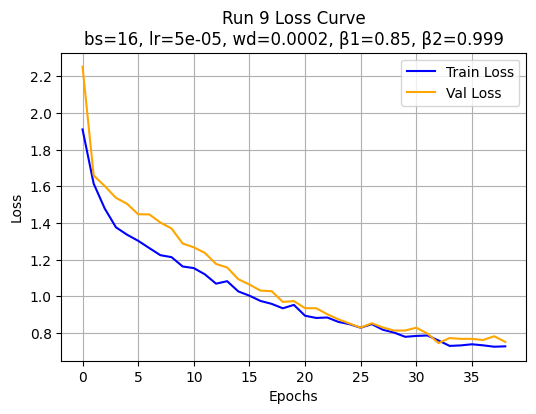

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
Test Accuracy: 0.6200, F1-score: 0.5931
Run 10: batch_size=16, lr=5e-05, weight_decay=0.0002, beta1=0.9, beta2=0.98
Epoch 1/60
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2112 - loss: 1.9311
Epoch 1: val_loss improved from inf to 2.49659, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.2115 - loss: 1.9304 - val_accuracy: 0.1267 - val_loss: 2.4966 - learning_rate: 5.0000e-05
Epoch 2/60
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3384 - loss: 1.6343
Epoch 2: val_loss improved from 2.49659 to 1.62849, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3384 - loss: 1.6341 - val_accuracy: 0.2483 - val_loss: 1.6285 - learning_rate: 5.0000e-05
Epoch 3/60
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4139 - loss: 1.4612
Epoch 3: val_loss improved from 1.62849 to 1.48022, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━

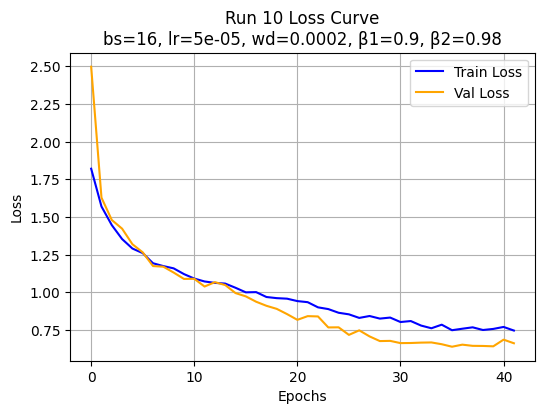

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
Test Accuracy: 0.6833, F1-score: 0.6718
Run 11: batch_size=16, lr=5e-05, weight_decay=0.0002, beta1=0.9, beta2=0.99
Epoch 1/60
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2109 - loss: 1.9829
Epoch 1: val_loss improved from inf to 2.26005, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.2112 - loss: 1.9825 - val_accuracy: 0.1267 - val_loss: 2.2600 - learning_rate: 5.0000e-05
Epoch 2/60
446/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3430 - loss: 1.6956
Epoch 2: val_loss improved from 2.26005 to 1.65561, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3432 - loss: 1.6952 - val_accuracy: 0.3400 - val_loss: 1.6556 - learning_rate: 5.0000e-05
Epoch 3/60
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3936 - loss: 1.5532
Epoch 3: val_loss improved from 1.65561 to 1.52497, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━

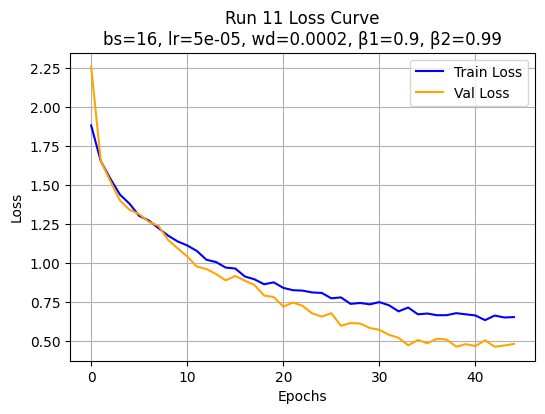

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
Test Accuracy: 0.7850, F1-score: 0.7773
Run 12: batch_size=16, lr=5e-05, weight_decay=0.0002, beta1=0.9, beta2=0.999
Epoch 1/60
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1865 - loss: 2.0029
Epoch 1: val_loss improved from inf to 2.23290, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.1869 - loss: 2.0021 - val_accuracy: 0.1633 - val_loss: 2.2329 - learning_rate: 5.0000e-05
Epoch 2/60
441/450 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3121 - loss: 1.6843
Epoch 2: val_loss improved from 2.23290 to 1.67247, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3125 - loss: 1.6835 - val_accuracy: 0.3133 - val_loss: 1.6725 - learning_rate: 5.0000e-05
Epoch 3/60
446/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3750 - loss: 1.5484
Epoch 3: val_loss improved from 1.67247 to 1.49557, saving model to enhanced_best_model.keras
450/450 ━━━━━━━

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step
Test Accuracy: 0.8700, F1-score: 0.8663
Run 13: batch_size=16, lr=5e-05, weight_decay=0.0005, beta1=0.85, beta2=0.98
Epoch 1/60
444/450 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2062 - loss: 1.9973
Epoch 1: val_loss improved from inf to 2.16016, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.2072 - loss: 1.9955 - val_accuracy: 0.1267 - val_loss: 2.1602 - learning_rate: 5.0000e-05
Epoch 2/60
443/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3647 - loss: 1.6486
Epoch 2: val_loss improved from 2.16016 to 1.60488, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3651 - loss: 1.6477 - val_accuracy: 0.3100 - val_loss: 1.6049 - learning_rate: 5.0000e-05
Epoch 3/60
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4084 - loss: 1.5159
Epoch 3: val_loss improved from 1.60488 to 1.49937, saving model to enhanced_best_model.keras
450/450 ━━━━━━━

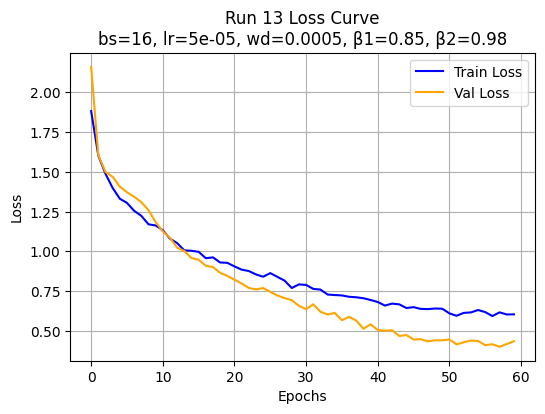

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step
Test Accuracy: 0.8250, F1-score: 0.8207
Run 14: batch_size=16, lr=5e-05, weight_decay=0.0005, beta1=0.85, beta2=0.99
Epoch 1/60
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2552 - loss: 1.9372
Epoch 1: val_loss improved from inf to 2.27478, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.2553 - loss: 1.9368 - val_accuracy: 0.1267 - val_loss: 2.2748 - learning_rate: 5.0000e-05
Epoch 2/60
445/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3397 - loss: 1.7005
Epoch 2: val_loss improved from 2.27478 to 1.80319, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3399 - loss: 1.7002 - val_accuracy: 0.2617 - val_loss: 1.8032 - learning_rate: 5.0000e-05
Epoch 3/60
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3793 - loss: 1.6093
Epoch 3: val_loss improved from 1.80319 to 1.73872, saving model to enhanced_best_model.keras
450/450 ━━━━━━━

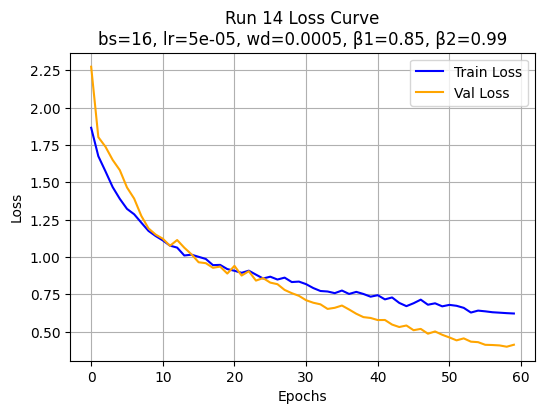

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step
Test Accuracy: 0.8533, F1-score: 0.8502
Run 15: batch_size=16, lr=5e-05, weight_decay=0.0005, beta1=0.85, beta2=0.999
Epoch 1/60
442/450 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1988 - loss: 1.9933
Epoch 1: val_loss improved from inf to 2.41322, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.1997 - loss: 1.9911 - val_accuracy: 0.1100 - val_loss: 2.4132 - learning_rate: 5.0000e-05
Epoch 2/60
446/450 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3096 - loss: 1.7055
Epoch 2: val_loss improved from 2.41322 to 1.75742, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.3098 - loss: 1.7051 - val_accuracy: 0.2483 - val_loss: 1.7574 - learning_rate: 5.0000e-05
Epoch 3/60
445/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3476 - loss: 1.5998
Epoch 3: val_loss improved from 1.75742 to 1.68155, saving model to enhanced_best_model.keras
450/450 ━━━━━

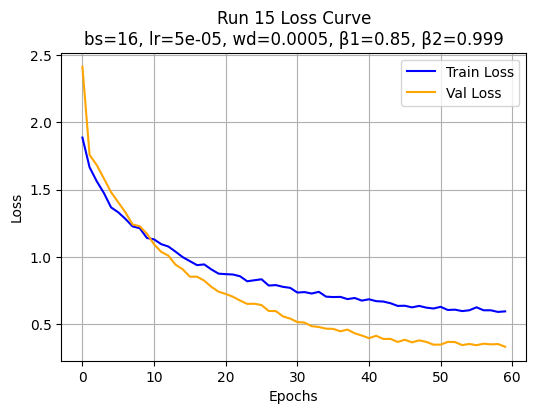

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
Test Accuracy: 0.8967, F1-score: 0.8964
Run 16: batch_size=16, lr=5e-05, weight_decay=0.0005, beta1=0.9, beta2=0.98
Epoch 1/60
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2504 - loss: 1.9333
Epoch 1: val_loss improved from inf to 2.08532, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.2506 - loss: 1.9328 - val_accuracy: 0.1750 - val_loss: 2.0853 - learning_rate: 5.0000e-05
Epoch 2/60
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3687 - loss: 1.5948
Epoch 2: val_loss improved from 2.08532 to 1.61398, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3688 - loss: 1.5947 - val_accuracy: 0.3100 - val_loss: 1.6140 - learning_rate: 5.0000e-05
Epoch 3/60
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4050 - loss: 1.4952
Epoch 3: val_loss improved from 1.61398 to 1.48944, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━

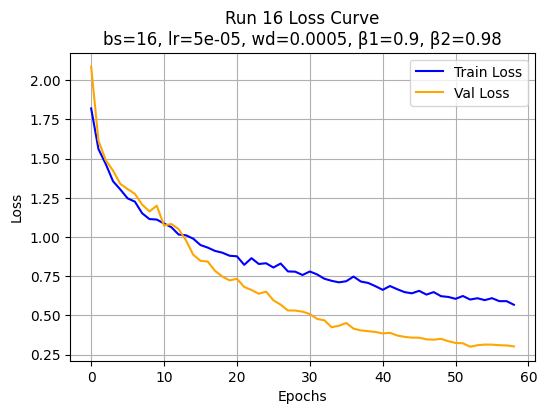

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step
Test Accuracy: 0.9133, F1-score: 0.9125
Run 17: batch_size=16, lr=5e-05, weight_decay=0.0005, beta1=0.9, beta2=0.99
Epoch 1/60
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2226 - loss: 1.9855
Epoch 1: val_loss improved from inf to 2.21388, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.2227 - loss: 1.9851 - val_accuracy: 0.1417 - val_loss: 2.2139 - learning_rate: 5.0000e-05
Epoch 2/60
445/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3557 - loss: 1.7105
Epoch 2: val_loss improved from 2.21388 to 1.68886, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3560 - loss: 1.7099 - val_accuracy: 0.2800 - val_loss: 1.6889 - learning_rate: 5.0000e-05
Epoch 3/60
441/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4034 - loss: 1.5602
Epoch 3: val_loss improved from 1.68886 to 1.56418, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━

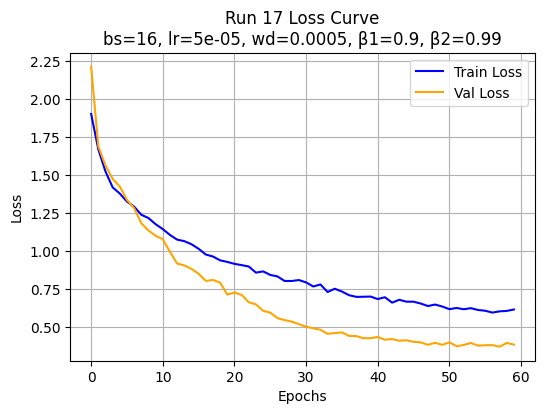

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
Test Accuracy: 0.8650, F1-score: 0.8645
Run 18: batch_size=16, lr=5e-05, weight_decay=0.0005, beta1=0.9, beta2=0.999
Epoch 1/60
445/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1970 - loss: 2.0532
Epoch 1: val_loss improved from inf to 2.30751, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.1975 - loss: 2.0522 - val_accuracy: 0.1267 - val_loss: 2.3075 - learning_rate: 5.0000e-05
Epoch 2/60
441/450 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3167 - loss: 1.7983
Epoch 2: val_loss improved from 2.30751 to 1.83185, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.3170 - loss: 1.7974 - val_accuracy: 0.1683 - val_loss: 1.8318 - learning_rate: 5.0000e-05
Epoch 3/60
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3643 - loss: 1.6425
Epoch 3: val_loss improved from 1.83185 to 1.71936, saving model to enhanced_best_model.keras
450/450 ━━━━━━━

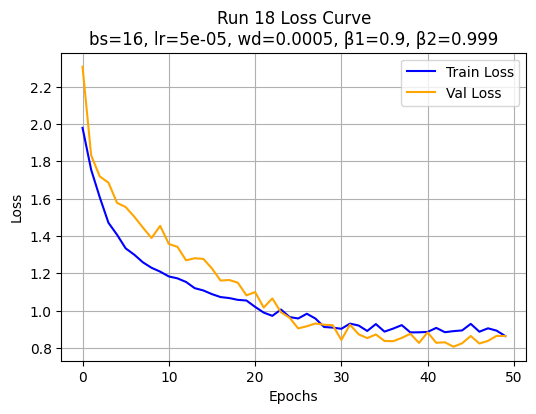

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
Test Accuracy: 0.6267, F1-score: 0.6091
Run 19: batch_size=16, lr=0.0001, weight_decay=0.0001, beta1=0.85, beta2=0.98
Epoch 1/60
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2343 - loss: 1.8984
Epoch 1: val_loss improved from inf to 2.30512, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.2347 - loss: 1.8975 - val_accuracy: 0.1283 - val_loss: 2.3051 - learning_rate: 1.0000e-04
Epoch 2/60
442/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3842 - loss: 1.5052
Epoch 2: val_loss improved from 2.30512 to 1.47519, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3847 - loss: 1.5039 - val_accuracy: 0.3667 - val_loss: 1.4752 - learning_rate: 1.0000e-04
Epoch 3/60
442/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4563 - loss: 1.3389
Epoch 3: val_loss improved from 1.47519 to 1.38803, saving model to enhanced_best_model.keras
450/450 ━━━━━━

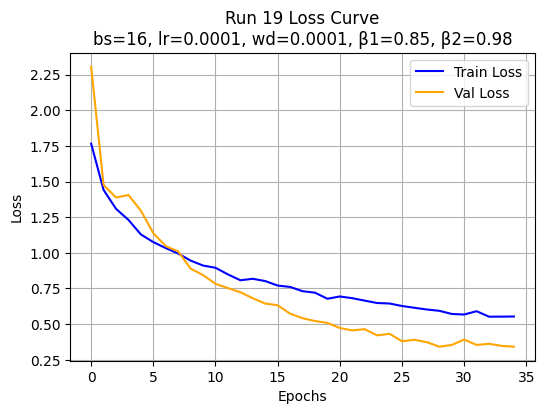

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
Test Accuracy: 0.8883, F1-score: 0.8864
Run 20: batch_size=16, lr=0.0001, weight_decay=0.0001, beta1=0.85, beta2=0.99
Epoch 1/60
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2407 - loss: 1.9018
Epoch 1: val_loss improved from inf to 2.30552, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.2411 - loss: 1.9011 - val_accuracy: 0.1267 - val_loss: 2.3055 - learning_rate: 1.0000e-04
Epoch 2/60
444/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3806 - loss: 1.5971
Epoch 2: val_loss improved from 2.30552 to 1.64601, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3808 - loss: 1.5963 - val_accuracy: 0.3250 - val_loss: 1.6460 - learning_rate: 1.0000e-04
Epoch 3/60
445/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4483 - loss: 1.4193
Epoch 3: val_loss improved from 1.64601 to 1.51148, saving model to enhanced_best_model.keras
450/450 ━━━━━━

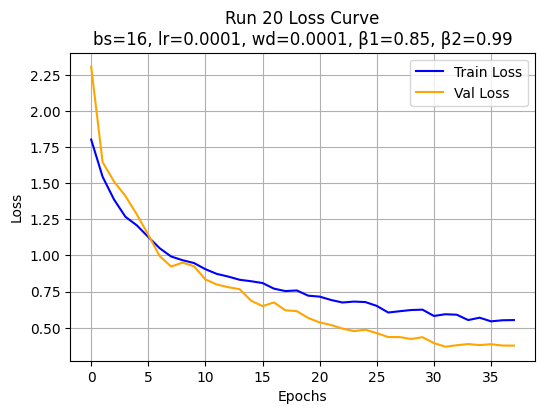

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
Test Accuracy: 0.8550, F1-score: 0.8536
Run 21: batch_size=16, lr=0.0001, weight_decay=0.0001, beta1=0.85, beta2=0.999
Epoch 1/60
446/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2341 - loss: 1.9131
Epoch 1: val_loss improved from inf to 2.38758, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.2347 - loss: 1.9115 - val_accuracy: 0.2217 - val_loss: 2.3876 - learning_rate: 1.0000e-04
Epoch 2/60
444/450 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4086 - loss: 1.4839
Epoch 2: val_loss improved from 2.38758 to 1.49736, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4091 - loss: 1.4830 - val_accuracy: 0.3633 - val_loss: 1.4974 - learning_rate: 1.0000e-04
Epoch 3/60
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4810 - loss: 1.3095
Epoch 3: val_loss improved from 1.49736 to 1.37494, saving model to enhanced_best_model.keras
450/450 ━━━━━

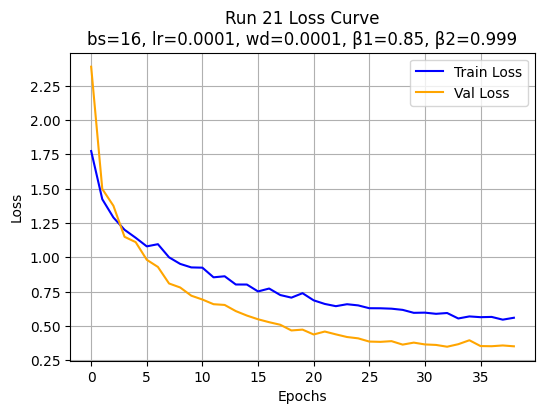

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
Test Accuracy: 0.8617, F1-score: 0.8557
Run 22: batch_size=16, lr=0.0001, weight_decay=0.0001, beta1=0.9, beta2=0.98
Epoch 1/60
442/450 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2355 - loss: 1.9407
Epoch 1: val_loss improved from inf to 2.32317, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.2370 - loss: 1.9376 - val_accuracy: 0.1967 - val_loss: 2.3232 - learning_rate: 1.0000e-04
Epoch 2/60
447/450 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4358 - loss: 1.4676
Epoch 2: val_loss improved from 2.32317 to 1.45622, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.4359 - loss: 1.4673 - val_accuracy: 0.2983 - val_loss: 1.4562 - learning_rate: 1.0000e-04
Epoch 3/60
443/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4827 - loss: 1.3162
Epoch 3: val_loss improved from 1.45622 to 1.29506, saving model to enhanced_best_model.keras
450/450 ━━━━━━

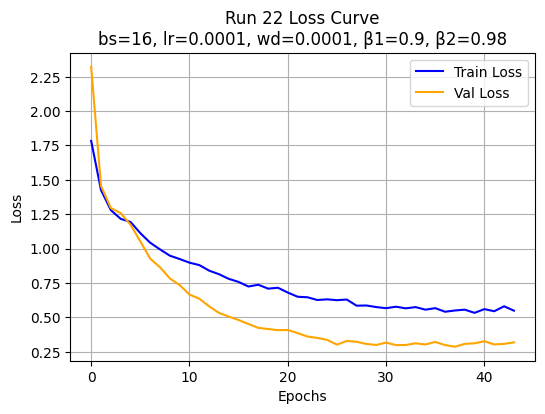

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step
Test Accuracy: 0.8950, F1-score: 0.8946
Run 23: batch_size=16, lr=0.0001, weight_decay=0.0001, beta1=0.9, beta2=0.99
Epoch 1/60
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2254 - loss: 1.9891
Epoch 1: val_loss improved from inf to 2.21346, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.2255 - loss: 1.9888 - val_accuracy: 0.1267 - val_loss: 2.2135 - learning_rate: 1.0000e-04
Epoch 2/60
445/450 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3915 - loss: 1.5501
Epoch 2: val_loss improved from 2.21346 to 1.52467, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3917 - loss: 1.5496 - val_accuracy: 0.3267 - val_loss: 1.5247 - learning_rate: 1.0000e-04
Epoch 3/60
441/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4422 - loss: 1.4054
Epoch 3: val_loss improved from 1.52467 to 1.46129, saving model to enhanced_best_model.keras
450/450 ━━━━━━

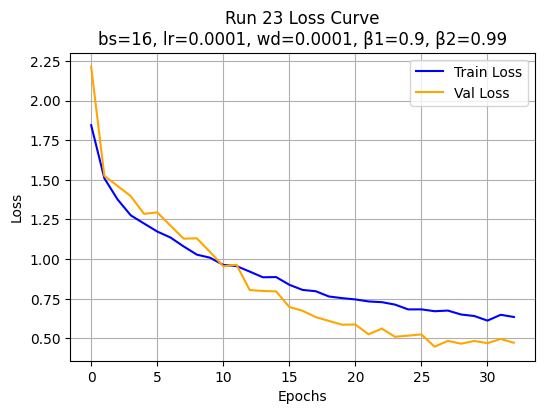

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step
Test Accuracy: 0.8417, F1-score: 0.8398
Run 24: batch_size=16, lr=0.0001, weight_decay=0.0001, beta1=0.9, beta2=0.999
Epoch 1/60
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2429 - loss: 1.9342
Epoch 1: val_loss improved from inf to 2.36269, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.2433 - loss: 1.9331 - val_accuracy: 0.1267 - val_loss: 2.3627 - learning_rate: 1.0000e-04
Epoch 2/60
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3979 - loss: 1.5155
Epoch 2: val_loss improved from 2.36269 to 1.42163, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3980 - loss: 1.5154 - val_accuracy: 0.4283 - val_loss: 1.4216 - learning_rate: 1.0000e-04
Epoch 3/60
443/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4595 - loss: 1.3489
Epoch 3: val_loss improved from 1.42163 to 1.26222, saving model to enhanced_best_model.keras
450/450 ━━━━━━

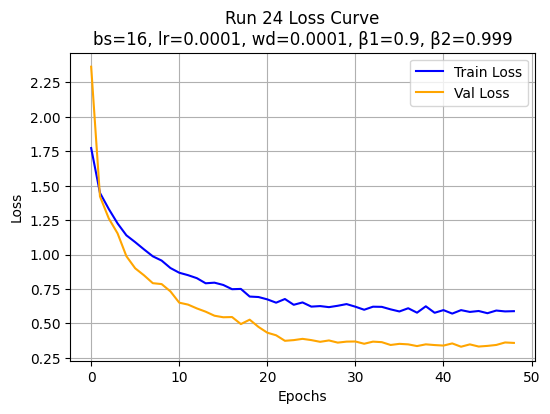

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
Test Accuracy: 0.8917, F1-score: 0.8918
Run 25: batch_size=16, lr=0.0001, weight_decay=0.0002, beta1=0.85, beta2=0.98
Epoch 1/60
444/450 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1881 - loss: 2.0242
Epoch 1: val_loss improved from inf to 2.21534, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.1894 - loss: 2.0215 - val_accuracy: 0.1467 - val_loss: 2.2153 - learning_rate: 1.0000e-04
Epoch 2/60
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3881 - loss: 1.5336
Epoch 2: val_loss improved from 2.21534 to 1.36735, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3883 - loss: 1.5331 - val_accuracy: 0.4583 - val_loss: 1.3673 - learning_rate: 1.0000e-04
Epoch 3/60
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4407 - loss: 1.3455
Epoch 3: val_loss improved from 1.36735 to 1.24631, saving model to enhanced_best_model.keras
450/450 ━━━━━━

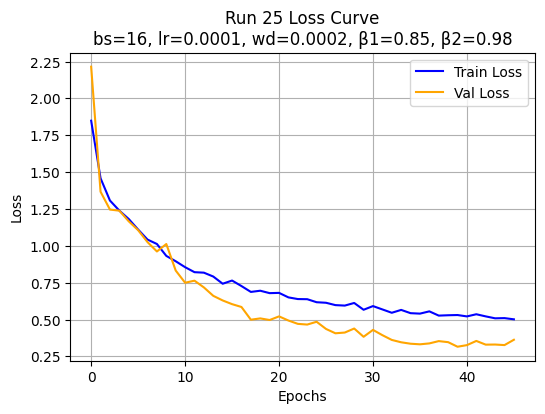

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
Test Accuracy: 0.8867, F1-score: 0.8862
Run 26: batch_size=16, lr=0.0001, weight_decay=0.0002, beta1=0.85, beta2=0.99
Epoch 1/60
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2766 - loss: 1.8425
Epoch 1: val_loss improved from inf to 2.56372, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.2769 - loss: 1.8416 - val_accuracy: 0.1267 - val_loss: 2.5637 - learning_rate: 1.0000e-04
Epoch 2/60
443/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4142 - loss: 1.4829
Epoch 2: val_loss improved from 2.56372 to 1.66421, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4142 - loss: 1.4825 - val_accuracy: 0.2667 - val_loss: 1.6642 - learning_rate: 1.0000e-04
Epoch 3/60
445/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4374 - loss: 1.3669
Epoch 3: val_loss improved from 1.66421 to 1.49025, saving model to enhanced_best_model.keras
450/450 ━━━━━━

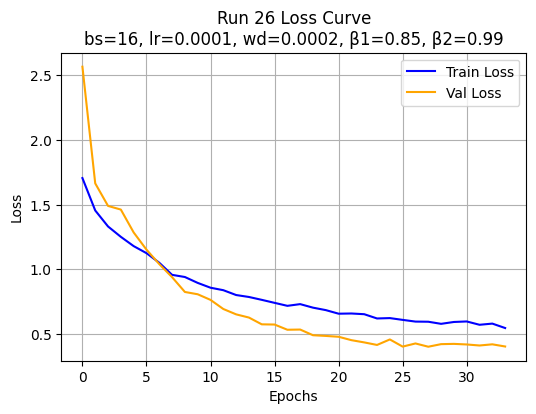

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
Test Accuracy: 0.8433, F1-score: 0.8386
Run 27: batch_size=16, lr=0.0001, weight_decay=0.0002, beta1=0.85, beta2=0.999
Epoch 1/60
447/450 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2063 - loss: 1.9158
Epoch 1: val_loss improved from inf to 2.11706, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.2071 - loss: 1.9146 - val_accuracy: 0.2233 - val_loss: 2.1171 - learning_rate: 1.0000e-04
Epoch 2/60
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4241 - loss: 1.5040
Epoch 2: val_loss improved from 2.11706 to 1.34710, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4241 - loss: 1.5038 - val_accuracy: 0.4567 - val_loss: 1.3471 - learning_rate: 1.0000e-04
Epoch 3/60
444/450 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4779 - loss: 1.3214
Epoch 3: val_loss improved from 1.34710 to 1.28929, saving model to enhanced_best_model.keras
450/450 ━━━━━

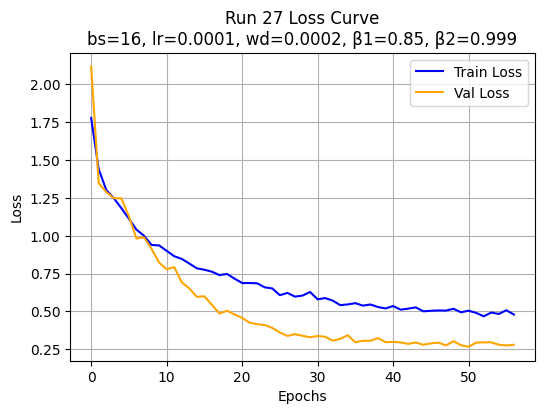

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
Test Accuracy: 0.8983, F1-score: 0.8954
Run 28: batch_size=16, lr=0.0001, weight_decay=0.0002, beta1=0.9, beta2=0.98
Epoch 1/60
444/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2348 - loss: 1.8972
Epoch 1: val_loss improved from inf to 2.22751, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.2360 - loss: 1.8945 - val_accuracy: 0.1283 - val_loss: 2.2275 - learning_rate: 1.0000e-04
Epoch 2/60
447/450 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4299 - loss: 1.4062
Epoch 2: val_loss improved from 2.22751 to 1.26404, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4300 - loss: 1.4058 - val_accuracy: 0.4233 - val_loss: 1.2640 - learning_rate: 1.0000e-04
Epoch 3/60
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4930 - loss: 1.2495
Epoch 3: val_loss improved from 1.26404 to 1.09009, saving model to enhanced_best_model.keras
450/450 ━━━━━━━

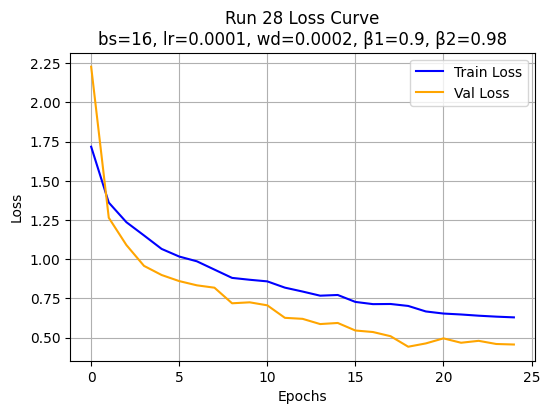

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
Test Accuracy: 0.8367, F1-score: 0.8336
Run 29: batch_size=16, lr=0.0001, weight_decay=0.0002, beta1=0.9, beta2=0.99
Epoch 1/60
447/450 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1984 - loss: 2.0166
Epoch 1: val_loss improved from inf to 2.25004, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.1990 - loss: 2.0153 - val_accuracy: 0.1267 - val_loss: 2.2500 - learning_rate: 1.0000e-04
Epoch 2/60
444/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3748 - loss: 1.5883
Epoch 2: val_loss improved from 2.25004 to 1.56600, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3752 - loss: 1.5874 - val_accuracy: 0.2967 - val_loss: 1.5660 - learning_rate: 1.0000e-04
Epoch 3/60
446/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4400 - loss: 1.3580
Epoch 3: val_loss improved from 1.56600 to 1.44838, saving model to enhanced_best_model.keras
450/450 ━━━━━━━

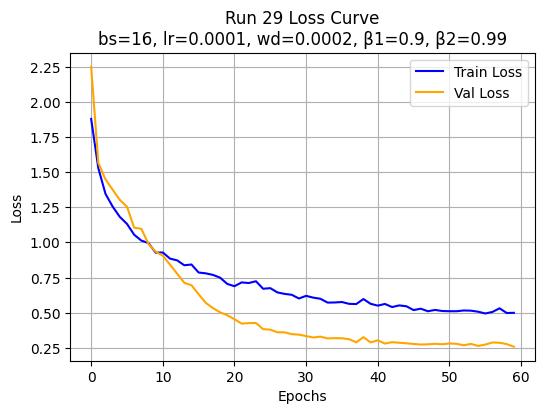

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step
Test Accuracy: 0.9233, F1-score: 0.9234
Run 30: batch_size=16, lr=0.0001, weight_decay=0.0002, beta1=0.9, beta2=0.999
Epoch 1/60
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2263 - loss: 1.8938
Epoch 1: val_loss improved from inf to 2.33265, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.2268 - loss: 1.8927 - val_accuracy: 0.2300 - val_loss: 2.3326 - learning_rate: 1.0000e-04
Epoch 2/60
444/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4076 - loss: 1.4519
Epoch 2: val_loss improved from 2.33265 to 1.30381, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4078 - loss: 1.4512 - val_accuracy: 0.5067 - val_loss: 1.3038 - learning_rate: 1.0000e-04
Epoch 3/60
443/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4649 - loss: 1.3081
Epoch 3: val_loss improved from 1.30381 to 1.15758, saving model to enhanced_best_model.keras
450/450 ━━━━━━

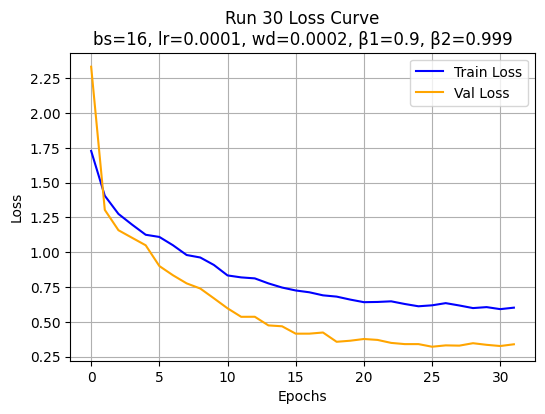

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
Test Accuracy: 0.9050, F1-score: 0.9047
Run 31: batch_size=16, lr=0.0001, weight_decay=0.0005, beta1=0.85, beta2=0.98
Epoch 1/60
445/450 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2340 - loss: 1.9477
Epoch 1: val_loss improved from inf to 2.33107, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.2350 - loss: 1.9450 - val_accuracy: 0.2333 - val_loss: 2.3311 - learning_rate: 1.0000e-04
Epoch 2/60
443/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4251 - loss: 1.4458
Epoch 2: val_loss improved from 2.33107 to 1.47265, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4253 - loss: 1.4452 - val_accuracy: 0.3500 - val_loss: 1.4726 - learning_rate: 1.0000e-04
Epoch 3/60
445/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4545 - loss: 1.3217
Epoch 3: val_loss improved from 1.47265 to 1.33527, saving model to enhanced_best_model.keras
450/450 ━━━━━━

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
Test Accuracy: 0.8667, F1-score: 0.8570
Run 32: batch_size=16, lr=0.0001, weight_decay=0.0005, beta1=0.85, beta2=0.99
Epoch 1/60
444/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2494 - loss: 1.8983
Epoch 1: val_loss improved from inf to 2.60486, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.2503 - loss: 1.8962 - val_accuracy: 0.1117 - val_loss: 2.6049 - learning_rate: 1.0000e-04
Epoch 2/60
444/450 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3953 - loss: 1.5267
Epoch 2: val_loss improved from 2.60486 to 1.66045, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3955 - loss: 1.5259 - val_accuracy: 0.2967 - val_loss: 1.6604 - learning_rate: 1.0000e-04
Epoch 3/60
443/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4297 - loss: 1.3697
Epoch 3: val_loss improved from 1.66045 to 1.60660, saving model to enhanced_best_model.keras
450/450 ━━━━━━

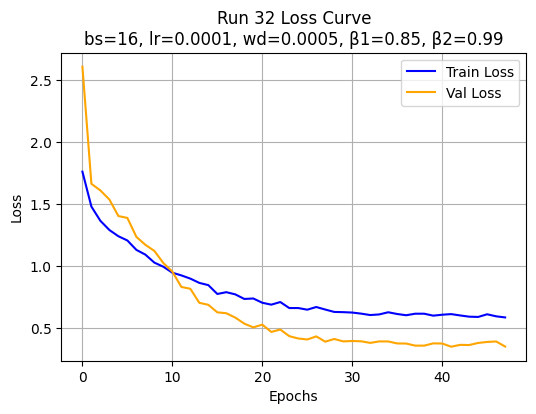

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step
Test Accuracy: 0.8867, F1-score: 0.8846
Run 33: batch_size=16, lr=0.0001, weight_decay=0.0005, beta1=0.85, beta2=0.999
Epoch 1/60
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2339 - loss: 1.9395
Epoch 1: val_loss improved from inf to 2.27099, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.2343 - loss: 1.9386 - val_accuracy: 0.2583 - val_loss: 2.2710 - learning_rate: 1.0000e-04
Epoch 2/60
445/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3844 - loss: 1.5189
Epoch 2: val_loss improved from 2.27099 to 1.41291, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3847 - loss: 1.5182 - val_accuracy: 0.4217 - val_loss: 1.4129 - learning_rate: 1.0000e-04
Epoch 3/60
445/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4641 - loss: 1.3171
Epoch 3: val_loss improved from 1.41291 to 1.25404, saving model to enhanced_best_model.keras
450/450 ━━━━━

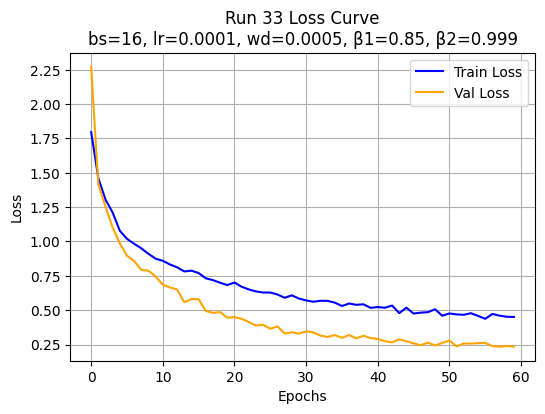

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step
Test Accuracy: 0.9133, F1-score: 0.9123
Run 34: batch_size=16, lr=0.0001, weight_decay=0.0005, beta1=0.9, beta2=0.98
Epoch 1/60
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2567 - loss: 1.8447
Epoch 1: val_loss improved from inf to 2.65008, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.2570 - loss: 1.8439 - val_accuracy: 0.1267 - val_loss: 2.6501 - learning_rate: 1.0000e-04
Epoch 2/60
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3930 - loss: 1.4771
Epoch 2: val_loss improved from 2.65008 to 1.67575, saving model to enhanced_best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.3930 - loss: 1.4768 - val_accuracy: 0.3633 - val_loss: 1.6758 - learning_rate: 1.0000e-04
Epoch 3/60
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4582 - loss: 1.3153
Epoch 3: val_loss improved from 1.67575 to 1.55729, saving model to enhanced_best_model.keras
450/450 ━━━━━━━

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step
Test Accuracy: 0.8300, F1-score: 0.8256
Run 35: batch_size=16, lr=0.0001, weight_decay=0.0005, beta1=0.9, beta2=0.99
Epoch 1/60


KeyboardInterrupt: 

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

# ===== HYPERPARAMETER GRID =====
batch_sizes = [16, 32, 64]
learning_rates = [5e-5, 1e-4, 2e-4]
weight_decays = [1e-4, 2e-4, 5e-4]
beta_1_list = [0.85, 0.9]
beta_2_list = [0.98, 0.99, 0.999]

# Fixed hyperparameters
epochs = 60
patience_es = 6
patience_lr = 3
min_delta = 5e-4
checkpoint_path = "enhanced_best_model.keras"
dropout_rates = [0.1, 0.1, 0.15, 0.2, 0.25, 0.5]
alpha = 1.0
snr_range = (5, 25)
augmentation_factor = 2

results = []

# ===== MANUAL GRID SEARCH WITH LOSS PLOTS =====
for idx, (batch_size, lr, wd, b1, b2) in enumerate(itertools.product(batch_sizes, learning_rates, weight_decays, beta_1_list, beta_2_list)):
    print("="*60)
    print(f"Run {idx+1}: batch_size={batch_size}, lr={lr}, weight_decay={wd}, beta1={b1}, beta2={b2}")

    # Create model
    model = EnhancedOptimizedCNN(input_shape=(28,28,2), num_classes=num_classes, alpha=alpha)
    enhanced_model = model.create_model(dropout_rates)

    # Create augmentor
    augmentor = AdvancedRFAugmentation(snr_range=snr_range, augmentation_factor=augmentation_factor)

    # Create training pipeline
    pipeline = ClassWeightedTrainingPipeline(enhanced_model, augmentor, classes)

    # Train model
    history = pipeline.train_enhanced_model(
        X_train=Xtrain,
        y_train=Ytrain,
        Xtest=Xtest,
        Ytest=Ytest,
        epochs=epochs,
        batch_size=batch_size,
        lr=lr,
        weight_decay=wd,
        beta_1=b1,
        beta_2=b2,
        patience_es=patience_es,
        patience_lr=patience_lr,
        min_delta=min_delta,
        checkpoint_path=checkpoint_path
    )

    # Plot loss curve for this run
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
    plt.title(f"Run {idx+1} Loss Curve\nbs={batch_size}, lr={lr}, wd={wd}, β1={b1}, β2={b2}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate on test set
    y_pred_probs = enhanced_model.predict(Xtest)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(Ytest, axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Test Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

    results.append({
        'batch_size': batch_size,
        'lr': lr,
        'weight_decay': wd,
        'beta_1': b1,
        'beta_2': b2,
        'accuracy': acc,
        'f1_score': f1
    })

# ===== Convert results to DataFrame for analysis =====
results_df = pd.DataFrame(results)
print("\nAll results sorted by accuracy:")
print(results_df.sort_values(by='accuracy', ascending=False))


In [ ]:
import optuna
from sklearn.metrics import f1_score, accuracy_score

# Define the objective function for Optuna
def objective(trial):
    # Suggest dropout rates for 6 layers
    dropout_rates = [
        trial.suggest_float("dropout0", 0.05, 0.15),
        trial.suggest_float("dropout1", 0.05, 0.15),
        trial.suggest_float("dropout2", 0.1, 0.2),
        trial.suggest_float("dropout3", 0.15, 0.25),
        trial.suggest_float("dropout4", 0.2, 0.3),
        trial.suggest_float("dropout_final", 0.3, 0.5),
    ]

    # Create model with suggested dropout rates
    cnn = EnhancedOptimizedCNN(input_shape=input_shape, num_classes=num_classes, alpha=alpha)
    model = cnn.create_model(dropout_rates)

    # Create pipeline
    pipeline = ClassWeightedTrainingPipeline(model, enhanced_augmentor, classes)

    try:
        history = pipeline.train_enhanced_model(
            X_train=Xtrain,
            y_train=Ytrain,
            Xtest=Xtest,
            Ytest=Ytest,
            epochs=15,  # reduced for speed
            batch_size=batch_size,
            lr=learning_rate,
            weight_decay=weight_decay,
            beta_1=beta_1,
            beta_2=beta_2,
            patience_es=3,
            patience_lr=2,
            min_delta=min_delta,
            checkpoint_path=f"optuna_trial_model.keras"
        )
    except Exception as e:
        print(f"Trial failed due to: {e}")
        return 0.0

    # Evaluate
    y_pred_probs = model.predict(Xtest)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(Ytest, axis=1)

    return f1_score(y_true, y_pred, average='weighted')

# ✅ Create and run the study
study = optuna.create_study(direction="maximize", study_name="dropout_optimization")
study.optimize(objective, n_trials=25)

# ✅ Print best result
print("Best F1-score:", study.best_value)
print("Best dropout rates:")
for key, value in study.best_params.items():
    print(f"  {key}: {value:.4f}")


[I 2025-08-15 06:29:23,416] A new study created in memory with name: dropout_optimization


Epoch 1/15
293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2348 - loss: 1.9783
Epoch 1: val_loss improved from inf to 2.40615, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.2373 - loss: 1.9729 - val_accuracy: 0.1167 - val_loss: 2.4061 - learning_rate: 1.0000e-04
Epoch 2/15
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4394 - loss: 1.3844
Epoch 2: val_loss improved from 2.40615 to 2.11150, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4395 - loss: 1.3840 - val_accuracy: 0.1900 - val_loss: 2.1115 - learning_rate: 1.0000e-04
Epoch 3/15
297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4987 - loss: 1.2057
Epoch 3: val_loss improved from 2.11150 to 1.42761, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4988 - loss: 1.2052 - val_accuracy: 0.3367 - val_loss: 1.4276 - learning_rate: 1.0000e-04
Epoch 4/15
294/300 ━━━━━━━━━━━

[I 2025-08-15 06:30:31,359] Trial 0 finished with value: 0.6399471321147119 and parameters: {'dropout0': 0.12794910828262507, 'dropout1': 0.13285319565509052, 'dropout2': 0.1256699445765552, 'dropout3': 0.2187688107232691, 'dropout4': 0.28007800238095504, 'dropout_final': 0.4124261690276993}. Best is trial 0 with value: 0.6399471321147119.


Epoch 1/15
297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2238 - loss: 1.9194
Epoch 1: val_loss improved from inf to 2.79857, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.2250 - loss: 1.9173 - val_accuracy: 0.1133 - val_loss: 2.7986 - learning_rate: 1.0000e-04
Epoch 2/15
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4543 - loss: 1.4299
Epoch 2: val_loss improved from 2.79857 to 2.20613, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4545 - loss: 1.4295 - val_accuracy: 0.1383 - val_loss: 2.2061 - learning_rate: 1.0000e-04
Epoch 3/15
293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5288 - loss: 1.2079
Epoch 3: val_loss improved from 2.20613 to 1.46593, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5290 - loss: 1.2069 - val_accuracy: 0.2333 - val_loss: 1.4659 - learning_rate: 1.0000e-04
Epoch 4/15
299/300 ━━━━━━━━━━━

[I 2025-08-15 06:31:33,825] Trial 1 finished with value: 0.6919796999792655 and parameters: {'dropout0': 0.05632609873009092, 'dropout1': 0.07386085225997116, 'dropout2': 0.185406068096538, 'dropout3': 0.1947088964026202, 'dropout4': 0.23771318900608268, 'dropout_final': 0.31115369814786464}. Best is trial 1 with value: 0.6919796999792655.


Epoch 1/15
293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2430 - loss: 1.9400
Epoch 1: val_loss improved from inf to 2.30776, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.2450 - loss: 1.9358 - val_accuracy: 0.1133 - val_loss: 2.3078 - learning_rate: 1.0000e-04
Epoch 2/15
292/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4367 - loss: 1.4449
Epoch 2: val_loss improved from 2.30776 to 2.11614, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4374 - loss: 1.4427 - val_accuracy: 0.1300 - val_loss: 2.1161 - learning_rate: 1.0000e-04
Epoch 3/15
292/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5043 - loss: 1.2097
Epoch 3: val_loss improved from 2.11614 to 1.50742, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5049 - loss: 1.2088 - val_accuracy: 0.2967 - val_loss: 1.5074 - learning_rate: 1.0000e-04
Epoch 4/15
299/300 ━━━━━━━━━━━

[I 2025-08-15 06:32:42,088] Trial 2 finished with value: 0.601274463451424 and parameters: {'dropout0': 0.07580148279109707, 'dropout1': 0.060777349791541174, 'dropout2': 0.19102837682138624, 'dropout3': 0.16533090365213318, 'dropout4': 0.27880966791357176, 'dropout_final': 0.3020118211994435}. Best is trial 1 with value: 0.6919796999792655.


Epoch 1/15
294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2427 - loss: 1.9272
Epoch 1: val_loss improved from inf to 2.23331, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.2448 - loss: 1.9228 - val_accuracy: 0.1150 - val_loss: 2.2333 - learning_rate: 1.0000e-04
Epoch 2/15
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4625 - loss: 1.3866
Epoch 2: val_loss improved from 2.23331 to 1.71607, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4626 - loss: 1.3861 - val_accuracy: 0.2650 - val_loss: 1.7161 - learning_rate: 1.0000e-04
Epoch 3/15
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5104 - loss: 1.2194
Epoch 3: val_loss improved from 1.71607 to 1.22444, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5105 - loss: 1.2188 - val_accuracy: 0.3633 - val_loss: 1.2244 - learning_rate: 1.0000e-04
Epoch 4/15
295/300 ━━━━━━━━━━━

[I 2025-08-15 06:33:53,940] Trial 3 finished with value: 0.6563114523002054 and parameters: {'dropout0': 0.10165402131550016, 'dropout1': 0.07724055343362148, 'dropout2': 0.14477258426315806, 'dropout3': 0.24162183033519813, 'dropout4': 0.277985558686111, 'dropout_final': 0.4224350370125263}. Best is trial 1 with value: 0.6919796999792655.


Epoch 1/15
293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2355 - loss: 1.8754
Epoch 1: val_loss improved from inf to 2.50251, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.2370 - loss: 1.8721 - val_accuracy: 0.1133 - val_loss: 2.5025 - learning_rate: 1.0000e-04
Epoch 2/15
295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3843 - loss: 1.4831
Epoch 2: val_loss improved from 2.50251 to 2.09805, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3849 - loss: 1.4820 - val_accuracy: 0.1917 - val_loss: 2.0980 - learning_rate: 1.0000e-04
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4723 - loss: 1.2686
Epoch 3: val_loss improved from 2.09805 to 1.33242, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4723 - loss: 1.2685 - val_accuracy: 0.4283 - val_loss: 1.3324 - learning_rate: 1.0000e-04
Epoch 4/15
297/300 ━━━━━━━━━━━

[I 2025-08-15 06:34:57,440] Trial 4 finished with value: 0.6639233195355869 and parameters: {'dropout0': 0.12172195239274411, 'dropout1': 0.12172763389322469, 'dropout2': 0.18388305937369462, 'dropout3': 0.17507364059302444, 'dropout4': 0.25417595690995126, 'dropout_final': 0.4896473552421831}. Best is trial 1 with value: 0.6919796999792655.


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2130 - loss: 1.9817
Epoch 1: val_loss improved from inf to 2.48767, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.2133 - loss: 1.9812 - val_accuracy: 0.1150 - val_loss: 2.4877 - learning_rate: 1.0000e-04
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4430 - loss: 1.4442
Epoch 2: val_loss improved from 2.48767 to 2.06003, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.4430 - loss: 1.4439 - val_accuracy: 0.2183 - val_loss: 2.0600 - learning_rate: 1.0000e-04
Epoch 3/15
295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5078 - loss: 1.2144
Epoch 3: val_loss improved from 2.06003 to 1.42306, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5080 - loss: 1.2138 - val_accuracy: 0.3517 - val_loss: 1.4231 - learning_rate: 1.0000e-04
Epoch 4/15
295/300 ━━━━━━━━━━━

[I 2025-08-15 06:36:14,831] Trial 5 finished with value: 0.5989520679842019 and parameters: {'dropout0': 0.0874439376110318, 'dropout1': 0.12816819126616608, 'dropout2': 0.19640990811975495, 'dropout3': 0.17021746529903803, 'dropout4': 0.283274093663073, 'dropout_final': 0.35953202416545127}. Best is trial 1 with value: 0.6919796999792655.


Epoch 1/15
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2448 - loss: 1.8947
Epoch 1: val_loss improved from inf to 2.51463, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.2454 - loss: 1.8932 - val_accuracy: 0.1133 - val_loss: 2.5146 - learning_rate: 1.0000e-04
Epoch 2/15
291/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4183 - loss: 1.4766
Epoch 2: val_loss improved from 2.51463 to 2.30827, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4189 - loss: 1.4750 - val_accuracy: 0.1167 - val_loss: 2.3083 - learning_rate: 1.0000e-04
Epoch 3/15
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4746 - loss: 1.3097
Epoch 3: val_loss improved from 2.30827 to 1.71166, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4746 - loss: 1.3095 - val_accuracy: 0.2083 - val_loss: 1.7117 - learning_rate: 1.0000e-04
Epoch 4/15
299/300 ━━━━━━━━━━━

[I 2025-08-15 06:37:22,122] Trial 6 finished with value: 0.5562098428269067 and parameters: {'dropout0': 0.11094139552796128, 'dropout1': 0.11496994534644202, 'dropout2': 0.1725395016733971, 'dropout3': 0.20550723311378777, 'dropout4': 0.24165055476040434, 'dropout_final': 0.41704500343133033}. Best is trial 1 with value: 0.6919796999792655.


Epoch 1/15
294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2170 - loss: 1.9664
Epoch 1: val_loss improved from inf to 2.61719, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.2185 - loss: 1.9633 - val_accuracy: 0.1133 - val_loss: 2.6172 - learning_rate: 1.0000e-04
Epoch 2/15
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4063 - loss: 1.5407
Epoch 2: val_loss improved from 2.61719 to 1.90829, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4068 - loss: 1.5396 - val_accuracy: 0.1867 - val_loss: 1.9083 - learning_rate: 1.0000e-04
Epoch 3/15
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4954 - loss: 1.2932
Epoch 3: val_loss improved from 1.90829 to 1.29567, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4955 - loss: 1.2929 - val_accuracy: 0.3350 - val_loss: 1.2957 - learning_rate: 1.0000e-04
Epoch 4/15
292/300 ━━━━━━━━━━━

[I 2025-08-15 06:38:33,069] Trial 7 finished with value: 0.6336158360247547 and parameters: {'dropout0': 0.11045394128316458, 'dropout1': 0.12241183279513175, 'dropout2': 0.1720733717301617, 'dropout3': 0.21036658338671574, 'dropout4': 0.2565450879921117, 'dropout_final': 0.4961822303111161}. Best is trial 1 with value: 0.6919796999792655.


Epoch 1/15
297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3170 - loss: 1.8330
Epoch 1: val_loss improved from inf to 2.47285, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.3177 - loss: 1.8309 - val_accuracy: 0.1133 - val_loss: 2.4728 - learning_rate: 1.0000e-04
Epoch 2/15
291/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4730 - loss: 1.3587
Epoch 2: val_loss improved from 2.47285 to 2.17265, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.4735 - loss: 1.3570 - val_accuracy: 0.1367 - val_loss: 2.1726 - learning_rate: 1.0000e-04
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5159 - loss: 1.1792
Epoch 3: val_loss improved from 2.17265 to 1.39927, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5159 - loss: 1.1791 - val_accuracy: 0.2967 - val_loss: 1.3993 - learning_rate: 1.0000e-04
Epoch 4/15
299/300 ━━━━━━━━━━━

[I 2025-08-15 06:39:45,815] Trial 8 finished with value: 0.666265669166357 and parameters: {'dropout0': 0.0878871147634615, 'dropout1': 0.13452366059950494, 'dropout2': 0.15801531129589502, 'dropout3': 0.16558632725739994, 'dropout4': 0.2610767348095481, 'dropout_final': 0.3336098335407946}. Best is trial 1 with value: 0.6919796999792655.


Epoch 1/15
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2421 - loss: 1.8736
Epoch 1: val_loss improved from inf to 2.29410, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.2428 - loss: 1.8719 - val_accuracy: 0.1133 - val_loss: 2.2941 - learning_rate: 1.0000e-04
Epoch 2/15
297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4598 - loss: 1.3963
Epoch 2: val_loss improved from 2.29410 to 1.70462, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4602 - loss: 1.3955 - val_accuracy: 0.2917 - val_loss: 1.7046 - learning_rate: 1.0000e-04
Epoch 3/15
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5430 - loss: 1.1866
Epoch 3: val_loss improved from 1.70462 to 1.19454, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5431 - loss: 1.1860 - val_accuracy: 0.4683 - val_loss: 1.1945 - learning_rate: 1.0000e-04
Epoch 4/15
294/300 ━━━━━━━━━━━

[I 2025-08-15 06:40:55,168] Trial 9 finished with value: 0.6901932514175882 and parameters: {'dropout0': 0.07562633341652802, 'dropout1': 0.1358318385715091, 'dropout2': 0.11202320383096567, 'dropout3': 0.1710229872675583, 'dropout4': 0.273714641157984, 'dropout_final': 0.3055931007810063}. Best is trial 1 with value: 0.6919796999792655.


Epoch 1/15
294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2696 - loss: 1.8375
Epoch 1: val_loss improved from inf to 2.47521, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.2711 - loss: 1.8338 - val_accuracy: 0.1133 - val_loss: 2.4752 - learning_rate: 1.0000e-04
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4606 - loss: 1.3786
Epoch 2: val_loss improved from 2.47521 to 1.88457, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4607 - loss: 1.3784 - val_accuracy: 0.1667 - val_loss: 1.8846 - learning_rate: 1.0000e-04
Epoch 3/15
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5062 - loss: 1.2050
Epoch 3: val_loss improved from 1.88457 to 1.17430, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5063 - loss: 1.2047 - val_accuracy: 0.4150 - val_loss: 1.1743 - learning_rate: 1.0000e-04
Epoch 4/15
295/300 ━━━━━━━━━━━

[I 2025-08-15 06:42:01,637] Trial 10 finished with value: 0.7712898417811362 and parameters: {'dropout0': 0.05512274018583891, 'dropout1': 0.08826680116957336, 'dropout2': 0.14756791826161975, 'dropout3': 0.19051307100982381, 'dropout4': 0.2099296656810884, 'dropout_final': 0.3689728395578631}. Best is trial 10 with value: 0.7712898417811362.


Epoch 1/15
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2606 - loss: 1.8761
Epoch 1: val_loss improved from inf to 2.31243, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.2616 - loss: 1.8741 - val_accuracy: 0.1217 - val_loss: 2.3124 - learning_rate: 1.0000e-04
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4842 - loss: 1.3071
Epoch 2: val_loss improved from 2.31243 to 1.86077, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4843 - loss: 1.3069 - val_accuracy: 0.1433 - val_loss: 1.8608 - learning_rate: 1.0000e-04
Epoch 3/15
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5329 - loss: 1.1380
Epoch 3: val_loss improved from 1.86077 to 1.22121, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5330 - loss: 1.1379 - val_accuracy: 0.3600 - val_loss: 1.2212 - learning_rate: 1.0000e-04
Epoch 4/15
297/300 ━━━━━━━━━━━

[I 2025-08-15 06:43:06,754] Trial 11 finished with value: 0.7869876928661402 and parameters: {'dropout0': 0.05079165343870702, 'dropout1': 0.09031615393766997, 'dropout2': 0.1438307951086798, 'dropout3': 0.19954176332216636, 'dropout4': 0.20795324577764918, 'dropout_final': 0.3662570192592909}. Best is trial 11 with value: 0.7869876928661402.


Epoch 1/15
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2484 - loss: 1.9161
Epoch 1: val_loss improved from inf to 2.45388, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.2492 - loss: 1.9143 - val_accuracy: 0.1167 - val_loss: 2.4539 - learning_rate: 1.0000e-04
Epoch 2/15
297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4323 - loss: 1.3773
Epoch 2: val_loss improved from 2.45388 to 1.64331, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4327 - loss: 1.3763 - val_accuracy: 0.3117 - val_loss: 1.6433 - learning_rate: 1.0000e-04
Epoch 3/15
297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5214 - loss: 1.1347
Epoch 3: val_loss improved from 1.64331 to 1.01915, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5216 - loss: 1.1344 - val_accuracy: 0.5033 - val_loss: 1.0192 - learning_rate: 1.0000e-04
Epoch 4/15
297/300 ━━━━━━━━━━━

[I 2025-08-15 06:44:16,072] Trial 12 finished with value: 0.8531072018121904 and parameters: {'dropout0': 0.050560159084810485, 'dropout1': 0.09596344881506919, 'dropout2': 0.14095851352146757, 'dropout3': 0.19122157721103616, 'dropout4': 0.20215071853827637, 'dropout_final': 0.37118623056333594}. Best is trial 12 with value: 0.8531072018121904.


Epoch 1/15
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2406 - loss: 1.9586
Epoch 1: val_loss improved from inf to 2.17620, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.2415 - loss: 1.9568 - val_accuracy: 0.1150 - val_loss: 2.1762 - learning_rate: 1.0000e-04
Epoch 2/15
292/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4853 - loss: 1.3860
Epoch 2: val_loss improved from 2.17620 to 1.89743, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4855 - loss: 1.3841 - val_accuracy: 0.2150 - val_loss: 1.8974 - learning_rate: 1.0000e-04
Epoch 3/15
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5214 - loss: 1.1916
Epoch 3: val_loss improved from 1.89743 to 1.28194, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5215 - loss: 1.1912 - val_accuracy: 0.4167 - val_loss: 1.2819 - learning_rate: 1.0000e-04
Epoch 4/15
298/300 ━━━━━━━━━━━

[I 2025-08-15 06:45:20,878] Trial 13 finished with value: 0.7021378926752705 and parameters: {'dropout0': 0.050931009391562164, 'dropout1': 0.10165598842449682, 'dropout2': 0.13197830038561847, 'dropout3': 0.22803689939486937, 'dropout4': 0.20053795386405784, 'dropout_final': 0.37817872200182506}. Best is trial 12 with value: 0.8531072018121904.


Epoch 1/15
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2060 - loss: 1.9486
Epoch 1: val_loss improved from inf to 2.24780, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.2064 - loss: 1.9476 - val_accuracy: 0.1133 - val_loss: 2.2478 - learning_rate: 1.0000e-04
Epoch 2/15
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3748 - loss: 1.5706
Epoch 2: val_loss improved from 2.24780 to 1.96457, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.3752 - loss: 1.5698 - val_accuracy: 0.1150 - val_loss: 1.9646 - learning_rate: 1.0000e-04
Epoch 3/15
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4474 - loss: 1.3784
Epoch 3: val_loss improved from 1.96457 to 1.59765, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4475 - loss: 1.3782 - val_accuracy: 0.2283 - val_loss: 1.5976 - learning_rate: 1.0000e-04
Epoch 4/15
293/300 ━━━━━━━━━━━

[I 2025-08-15 06:46:39,041] Trial 14 finished with value: 0.5628171052197368 and parameters: {'dropout0': 0.14355222139305157, 'dropout1': 0.10163956066114307, 'dropout2': 0.13385649057739937, 'dropout3': 0.18682902958712455, 'dropout4': 0.2218370722448351, 'dropout_final': 0.4498955709878546}. Best is trial 12 with value: 0.8531072018121904.


Epoch 1/15
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2880 - loss: 1.8297
Epoch 1: val_loss improved from inf to 2.43972, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.2887 - loss: 1.8280 - val_accuracy: 0.1133 - val_loss: 2.4397 - learning_rate: 1.0000e-04
Epoch 2/15
294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4817 - loss: 1.3210
Epoch 2: val_loss improved from 2.43972 to 1.53209, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4823 - loss: 1.3196 - val_accuracy: 0.3900 - val_loss: 1.5321 - learning_rate: 1.0000e-04
Epoch 3/15
295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5403 - loss: 1.1346
Epoch 3: val_loss improved from 1.53209 to 0.97778, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5406 - loss: 1.1338 - val_accuracy: 0.5833 - val_loss: 0.9778 - learning_rate: 1.0000e-04
Epoch 4/15
297/300 ━━━━━━━━━━━

[I 2025-08-15 06:47:44,289] Trial 15 finished with value: 0.8169100606295374 and parameters: {'dropout0': 0.06892866081957491, 'dropout1': 0.0891252097308035, 'dropout2': 0.1011543435138627, 'dropout3': 0.15405665587405556, 'dropout4': 0.22281765695629588, 'dropout_final': 0.3452121766624118}. Best is trial 12 with value: 0.8531072018121904.


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2802 - loss: 1.8491
Epoch 1: val_loss improved from inf to 2.75657, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.2804 - loss: 1.8486 - val_accuracy: 0.1167 - val_loss: 2.7566 - learning_rate: 1.0000e-04
Epoch 2/15
292/300 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4599 - loss: 1.3717
Epoch 2: val_loss improved from 2.75657 to 2.13863, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4602 - loss: 1.3698 - val_accuracy: 0.2583 - val_loss: 2.1386 - learning_rate: 1.0000e-04
Epoch 3/15
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5204 - loss: 1.1602
Epoch 3: val_loss improved from 2.13863 to 1.24717, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5205 - loss: 1.1601 - val_accuracy: 0.4783 - val_loss: 1.2472 - learning_rate: 1.0000e-04
Epoch 4/15
297/300 ━━━━━━━━━━━

[I 2025-08-15 06:48:49,791] Trial 16 finished with value: 0.8126702678582208 and parameters: {'dropout0': 0.06926538380240407, 'dropout1': 0.0544591840685656, 'dropout2': 0.10778696294513238, 'dropout3': 0.15301292597747315, 'dropout4': 0.22535957735293274, 'dropout_final': 0.33915362894589157}. Best is trial 12 with value: 0.8531072018121904.


Epoch 1/15
294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2224 - loss: 1.8903
Epoch 1: val_loss improved from inf to 2.50547, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.2239 - loss: 1.8867 - val_accuracy: 0.1150 - val_loss: 2.5055 - learning_rate: 1.0000e-04
Epoch 2/15
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4251 - loss: 1.3935
Epoch 2: val_loss improved from 2.50547 to 1.87836, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4255 - loss: 1.3924 - val_accuracy: 0.2250 - val_loss: 1.8784 - learning_rate: 1.0000e-04
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5095 - loss: 1.1985
Epoch 3: val_loss improved from 1.87836 to 1.15387, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5096 - loss: 1.1984 - val_accuracy: 0.4267 - val_loss: 1.1539 - learning_rate: 1.0000e-04
Epoch 4/15
298/300 ━━━━━━━━━━━

[I 2025-08-15 06:49:51,095] Trial 17 finished with value: 0.8027868027753672 and parameters: {'dropout0': 0.06678054814695747, 'dropout1': 0.11059448987114125, 'dropout2': 0.1000789581662712, 'dropout3': 0.15760232436381327, 'dropout4': 0.2986076743383044, 'dropout_final': 0.3855097896101027}. Best is trial 12 with value: 0.8531072018121904.


Epoch 1/15
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3310 - loss: 1.8341
Epoch 1: val_loss improved from inf to 2.58244, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.3317 - loss: 1.8322 - val_accuracy: 0.1150 - val_loss: 2.5824 - learning_rate: 1.0000e-04
Epoch 2/15
292/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4801 - loss: 1.3003
Epoch 2: val_loss improved from 2.58244 to 1.82285, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.4805 - loss: 1.2990 - val_accuracy: 0.2517 - val_loss: 1.8229 - learning_rate: 1.0000e-04
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5355 - loss: 1.1285
Epoch 3: val_loss improved from 1.82285 to 1.27575, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5355 - loss: 1.1284 - val_accuracy: 0.3267 - val_loss: 1.2758 - learning_rate: 1.0000e-04
Epoch 4/15
295/300 ━━━━━━━━━━━

[I 2025-08-15 06:51:02,797] Trial 18 finished with value: 0.6776349921625269 and parameters: {'dropout0': 0.08527011664878058, 'dropout1': 0.14651541709877658, 'dropout2': 0.11880041872146735, 'dropout3': 0.1837801237467555, 'dropout4': 0.22085177597941882, 'dropout_final': 0.33919550820584105}. Best is trial 12 with value: 0.8531072018121904.


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2644 - loss: 1.8922
Epoch 1: val_loss improved from inf to 2.59920, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.2646 - loss: 1.8917 - val_accuracy: 0.1133 - val_loss: 2.5992 - learning_rate: 1.0000e-04
Epoch 2/15
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4657 - loss: 1.3874
Epoch 2: val_loss improved from 2.59920 to 1.96260, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4658 - loss: 1.3869 - val_accuracy: 0.1500 - val_loss: 1.9626 - learning_rate: 1.0000e-04
Epoch 3/15
294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5190 - loss: 1.1952
Epoch 3: val_loss improved from 1.96260 to 1.23757, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5192 - loss: 1.1945 - val_accuracy: 0.3633 - val_loss: 1.2376 - learning_rate: 1.0000e-04
Epoch 4/15
295/300 ━━━━━━━━━━━

[I 2025-08-15 06:52:12,850] Trial 19 finished with value: 0.7457140599884347 and parameters: {'dropout0': 0.06384257840701096, 'dropout1': 0.08815040273043256, 'dropout2': 0.15989562960710996, 'dropout3': 0.23866878831171415, 'dropout4': 0.23023955751223132, 'dropout_final': 0.3971772663536205}. Best is trial 12 with value: 0.8531072018121904.


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2593 - loss: 1.8084
Epoch 1: val_loss improved from inf to 2.23264, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - accuracy: 0.2595 - loss: 1.8080 - val_accuracy: 0.1133 - val_loss: 2.2326 - learning_rate: 1.0000e-04
Epoch 2/15
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4179 - loss: 1.4558
Epoch 2: val_loss improved from 2.23264 to 1.80916, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4183 - loss: 1.4551 - val_accuracy: 0.1917 - val_loss: 1.8092 - learning_rate: 1.0000e-04
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4732 - loss: 1.2882
Epoch 3: val_loss improved from 1.80916 to 1.29949, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4733 - loss: 1.2881 - val_accuracy: 0.4833 - val_loss: 1.2995 - learning_rate: 1.0000e-04
Epoch 4/15
300/300 ━━━━━━━━━━━

[I 2025-08-15 06:53:21,965] Trial 20 finished with value: 0.7075422725422726 and parameters: {'dropout0': 0.08076205772527043, 'dropout1': 0.07809999775196108, 'dropout2': 0.12074145273614954, 'dropout3': 0.18127927396803226, 'dropout4': 0.2090032094425894, 'dropout_final': 0.4469776414258598}. Best is trial 12 with value: 0.8531072018121904.


Epoch 1/15
295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2725 - loss: 1.8623
Epoch 1: val_loss improved from inf to 2.73946, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.2736 - loss: 1.8595 - val_accuracy: 0.1133 - val_loss: 2.7395 - learning_rate: 1.0000e-04
Epoch 2/15
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4631 - loss: 1.3793
Epoch 2: val_loss improved from 2.73946 to 1.83907, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4633 - loss: 1.3788 - val_accuracy: 0.2100 - val_loss: 1.8391 - learning_rate: 1.0000e-04
Epoch 3/15
293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5235 - loss: 1.1696
Epoch 3: val_loss improved from 1.83907 to 1.14198, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5238 - loss: 1.1687 - val_accuracy: 0.4650 - val_loss: 1.1420 - learning_rate: 1.0000e-04
Epoch 4/15
299/300 ━━━━━━━━━━━

[I 2025-08-15 06:54:30,510] Trial 21 finished with value: 0.7876631257338965 and parameters: {'dropout0': 0.06614099425911268, 'dropout1': 0.053955014946025726, 'dropout2': 0.10227310958470329, 'dropout3': 0.1537007350806595, 'dropout4': 0.221053066301747, 'dropout_final': 0.34537666722018867}. Best is trial 12 with value: 0.8531072018121904.


Epoch 1/15
292/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2596 - loss: 1.9116
Epoch 1: val_loss improved from inf to 2.37103, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.2628 - loss: 1.9046 - val_accuracy: 0.1167 - val_loss: 2.3710 - learning_rate: 1.0000e-04
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5045 - loss: 1.2754
Epoch 2: val_loss improved from 2.37103 to 1.65118, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5045 - loss: 1.2752 - val_accuracy: 0.2800 - val_loss: 1.6512 - learning_rate: 1.0000e-04
Epoch 3/15
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5564 - loss: 1.0941
Epoch 3: val_loss improved from 1.65118 to 1.09405, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5564 - loss: 1.0939 - val_accuracy: 0.4667 - val_loss: 1.0940 - learning_rate: 1.0000e-04
Epoch 4/15
291/300 ━━━━━━━━━━━

[I 2025-08-15 06:55:45,339] Trial 22 finished with value: 0.7460811610626632 and parameters: {'dropout0': 0.06315037463989243, 'dropout1': 0.06626563243227733, 'dropout2': 0.10872112460414347, 'dropout3': 0.15022551541243614, 'dropout4': 0.2302042846390964, 'dropout_final': 0.32390723230438595}. Best is trial 12 with value: 0.8531072018121904.


Epoch 1/15
293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2567 - loss: 1.9158
Epoch 1: val_loss improved from inf to 2.10168, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.2591 - loss: 1.9106 - val_accuracy: 0.2450 - val_loss: 2.1017 - learning_rate: 1.0000e-04
Epoch 2/15
292/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4801 - loss: 1.3662
Epoch 2: val_loss improved from 2.10168 to 1.37319, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4808 - loss: 1.3644 - val_accuracy: 0.3450 - val_loss: 1.3732 - learning_rate: 1.0000e-04
Epoch 3/15
294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5420 - loss: 1.1853
Epoch 3: val_loss improved from 1.37319 to 0.95181, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5423 - loss: 1.1844 - val_accuracy: 0.5633 - val_loss: 0.9518 - learning_rate: 1.0000e-04
Epoch 4/15
298/300 ━━━━━━━━━━━

[I 2025-08-15 06:56:53,410] Trial 23 finished with value: 0.8090432263809433 and parameters: {'dropout0': 0.07155656570191156, 'dropout1': 0.09464439079539647, 'dropout2': 0.11315062051589561, 'dropout3': 0.15976253381094674, 'dropout4': 0.2000632277730704, 'dropout_final': 0.34906397407497297}. Best is trial 12 with value: 0.8531072018121904.


Epoch 1/15
297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2726 - loss: 1.9600
Epoch 1: val_loss improved from inf to 2.32109, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.2736 - loss: 1.9571 - val_accuracy: 0.1150 - val_loss: 2.3211 - learning_rate: 1.0000e-04
Epoch 2/15
295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4846 - loss: 1.3174
Epoch 2: val_loss improved from 2.32109 to 1.66990, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4850 - loss: 1.3161 - val_accuracy: 0.2317 - val_loss: 1.6699 - learning_rate: 1.0000e-04
Epoch 3/15
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5539 - loss: 1.0935
Epoch 3: val_loss improved from 1.66990 to 1.13747, saving model to optuna_trial_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5539 - loss: 1.0934 - val_accuracy: 0.3883 - val_loss: 1.1375 - learning_rate: 1.0000e-04
Epoch 4/15
296/300 ━━━━━━━━━━━

[I 2025-08-15 06:57:59,527] Trial 24 finished with value: 0.7729173702221882 and parameters: {'dropout0': 0.0593222150409426, 'dropout1': 0.05047122924212069, 'dropout2': 0.13119861069385066, 'dropout3': 0.17743128253416326, 'dropout4': 0.24007599744522515, 'dropout_final': 0.3284581502468723}. Best is trial 12 with value: 0.8531072018121904.


Best F1-score: 0.8531072018121904
Best dropout rates:
  dropout0: 0.0506
  dropout1: 0.0960
  dropout2: 0.1410
  dropout3: 0.1912
  dropout4: 0.2022
  dropout_final: 0.3712


In [ ]:
import optuna
from sklearn.metrics import f1_score
import numpy as np

# Define the objective function for Optuna
def objective(trial):
    # Suggest alpha (width multiplier for CNN)
    alpha = trial.suggest_float("alpha", 0.5, 1.5)

    # Suggest learning rate
    learning_rate = trial.suggest_categorical("learning_rate", [5e-5, 1e-4, 2e-4])

    # Suggest weight decay
    weight_decay = trial.suggest_categorical("weight_decay", [1e-4, 2e-4, 5e-4])

    # Suggest beta parameters for AdamW
    beta_1 = trial.suggest_categorical("beta_1", [0.85, 0.9])
    beta_2 = trial.suggest_categorical("beta_2", [0.98, 0.99])

    # Suggest dropout rates for 6 layers
    dropout_rates = [
        trial.suggest_float("dropout0", 0.05, 0.15),
        trial.suggest_float("dropout1", 0.05, 0.15),
        trial.suggest_float("dropout2", 0.1, 0.2),
        trial.suggest_float("dropout3", 0.15, 0.25),
        trial.suggest_float("dropout4", 0.2, 0.3),
        trial.suggest_float("dropout_final", 0.3, 0.5),
    ]

    # Create model with suggested alpha and dropout rates
    cnn = EnhancedOptimizedCNN(input_shape=input_shape, num_classes=num_classes, alpha=alpha)
    model = cnn.create_model(dropout_rates)

    # Create augmentor (added based on NameError)
    enhanced_augmentor = AdvancedRFAugmentation(snr_range=snr_range, augmentation_factor=augmentation_factor)

    # Create pipeline
    pipeline = ClassWeightedTrainingPipeline(model, enhanced_augmentor, classes)

    try:
        # Train model with suggested hyperparameters
        history = pipeline.train_enhanced_model(
            X_train=Xtrain,
            y_train=Ytrain,
            Xtest=Xtest,
            Ytest=Ytest,
            epochs=15,          # reduced for speed during tuning
            batch_size=batch_size,  # keep fixed for memory constraints
            lr=learning_rate,
            weight_decay=weight_decay,
            beta_1=beta_1,
            beta_2=beta_2,
            patience_es=3,
            patience_lr=2,
            min_delta=1e-4,
            checkpoint_path=f"optuna_trial_model.keras"
        )
    except Exception as e:
        print(f"Trial failed due to: {e}")
        return 0.0  # return worst score if trial fails

    # Evaluate F1-score on validation/test set
    y_pred_probs = model.predict(Xtest)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(Ytest, axis=1)

    return f1_score(y_true, y_pred, average='weighted')


# =========================
# Create and run the Optuna study
# =========================
study = optuna.create_study(direction="maximize", study_name="full_hyperparam_optimization")
study.optimize(objective, n_trials=25)

# =========================
# Print best results
# =========================
print("Best F1-score:", study.best_value)
print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-08-20 09:18:31,462] A new study created in memory with name: full_hyperparam_optimization


Epoch 1/15
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3004 - loss: 1.7850
Epoch 1: val_loss improved from inf to 2.26292, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.3012 - loss: 1.7829 - val_accuracy: 0.2600 - val_loss: 2.2629 - learning_rate: 2.0000e-04
Epoch 2/15
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4512 - loss: 1.3687
Epoch 2: val_loss improved from 2.26292 to 1.33784, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4513 - loss: 1.3685 - val_accuracy: 0.3650 - val_loss: 1.3378 - learning_rate: 2.0000e-04
Epoch 3/15
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5126 - loss: 1.2173
Epoch 3: val_loss improved from 1.33784 to 1.08131, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5127 - loss: 1.2170 - val_accuracy: 0.4917 - val_loss: 1.0813 - learning_rate: 2.0000e-04
Epoch 4/15
521/525 ━━━━━━━━━━━

[I 2025-08-20 09:20:13,902] Trial 0 finished with value: 0.8689306449982965 and parameters: {'alpha': 0.8487709118326979, 'learning_rate': 0.0002, 'weight_decay': 0.0005, 'beta_1': 0.85, 'beta_2': 0.99, 'dropout0': 0.05499694432750838, 'dropout1': 0.13342797503399173, 'dropout2': 0.10308272667036196, 'dropout3': 0.1790784836761878, 'dropout4': 0.26575501674414503, 'dropout_final': 0.4838295850409239}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2623 - loss: 1.8739
Epoch 1: val_loss improved from inf to 1.95465, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.2628 - loss: 1.8725 - val_accuracy: 0.1917 - val_loss: 1.9546 - learning_rate: 2.0000e-04
Epoch 2/15
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4227 - loss: 1.4340
Epoch 2: val_loss improved from 1.95465 to 1.37987, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4228 - loss: 1.4338 - val_accuracy: 0.3800 - val_loss: 1.3799 - learning_rate: 2.0000e-04
Epoch 3/15
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4811 - loss: 1.3042
Epoch 3: val_loss improved from 1.37987 to 1.17862, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4813 - loss: 1.3038 - val_accuracy: 0.4367 - val_loss: 1.1786 - learning_rate: 2.0000e-04
Epoch 4/15
516/525 ━━━━━━━━━━━

[I 2025-08-20 09:21:43,252] Trial 1 finished with value: 0.8315727458456533 and parameters: {'alpha': 0.6756701495430697, 'learning_rate': 0.0002, 'weight_decay': 0.0001, 'beta_1': 0.85, 'beta_2': 0.99, 'dropout0': 0.09624565614852798, 'dropout1': 0.08063699787469276, 'dropout2': 0.10922511369604748, 'dropout3': 0.18966383272970355, 'dropout4': 0.25877206311461537, 'dropout_final': 0.48056601972981067}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2276 - loss: 1.9247
Epoch 1: val_loss improved from inf to 2.53125, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.2281 - loss: 1.9237 - val_accuracy: 0.1333 - val_loss: 2.5312 - learning_rate: 5.0000e-05
Epoch 2/15
521/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3877 - loss: 1.5490
Epoch 2: val_loss improved from 2.53125 to 1.90010, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.3878 - loss: 1.5486 - val_accuracy: 0.1600 - val_loss: 1.9001 - learning_rate: 5.0000e-05
Epoch 3/15
515/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4398 - loss: 1.4222
Epoch 3: val_loss improved from 1.90010 to 1.72055, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4400 - loss: 1.4216 - val_accuracy: 0.2483 - val_loss: 1.7205 - learning_rate: 5.0000e-05
Epoch 4/15
525/525 ━━━━━━━━━━

[I 2025-08-20 09:23:37,398] Trial 2 finished with value: 0.5158490051143984 and parameters: {'alpha': 1.1089841094016317, 'learning_rate': 5e-05, 'weight_decay': 0.0002, 'beta_1': 0.85, 'beta_2': 0.99, 'dropout0': 0.056921897171357885, 'dropout1': 0.07756406559291361, 'dropout2': 0.17933310009617542, 'dropout3': 0.21694379067588848, 'dropout4': 0.26951366808152655, 'dropout_final': 0.31636374728792416}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
516/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2755 - loss: 1.8748
Epoch 1: val_loss improved from inf to 2.15698, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.2768 - loss: 1.8713 - val_accuracy: 0.1767 - val_loss: 2.1570 - learning_rate: 2.0000e-04
Epoch 2/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4186 - loss: 1.4388
Epoch 2: val_loss improved from 2.15698 to 1.44851, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.4186 - loss: 1.4387 - val_accuracy: 0.3433 - val_loss: 1.4485 - learning_rate: 2.0000e-04
Epoch 3/15
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4540 - loss: 1.3306
Epoch 3: val_loss improved from 1.44851 to 1.24875, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4541 - loss: 1.3305 - val_accuracy: 0.4983 - val_loss: 1.2487 - learning_rate: 2.0000e-04
Epoch 4/15
519/525 ━━━━━━━━━━

[I 2025-08-20 09:25:33,406] Trial 3 finished with value: 0.7597071843423011 and parameters: {'alpha': 0.8176819413048503, 'learning_rate': 0.0002, 'weight_decay': 0.0001, 'beta_1': 0.9, 'beta_2': 0.98, 'dropout0': 0.11552392392295936, 'dropout1': 0.11122534733864325, 'dropout2': 0.1555613968039922, 'dropout3': 0.20119943800897577, 'dropout4': 0.2714519230054141, 'dropout_final': 0.48317532318715145}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
518/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3203 - loss: 1.7606
Epoch 1: val_loss improved from inf to 1.88843, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.3211 - loss: 1.7578 - val_accuracy: 0.2867 - val_loss: 1.8884 - learning_rate: 2.0000e-04
Epoch 2/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4627 - loss: 1.3222
Epoch 2: val_loss improved from 1.88843 to 1.27765, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.4627 - loss: 1.3221 - val_accuracy: 0.3750 - val_loss: 1.2777 - learning_rate: 2.0000e-04
Epoch 3/15
516/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4851 - loss: 1.2422
Epoch 3: val_loss improved from 1.27765 to 1.17234, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4852 - loss: 1.2419 - val_accuracy: 0.4083 - val_loss: 1.1723 - learning_rate: 2.0000e-04
Epoch 4/15
516/525 ━━━━━━━━━━

[I 2025-08-20 09:27:10,705] Trial 4 finished with value: 0.7180775714364638 and parameters: {'alpha': 0.7102401841492333, 'learning_rate': 0.0002, 'weight_decay': 0.0001, 'beta_1': 0.85, 'beta_2': 0.98, 'dropout0': 0.06486043871756089, 'dropout1': 0.13612148296286736, 'dropout2': 0.16506745156128655, 'dropout3': 0.1902693341165536, 'dropout4': 0.2662432130289909, 'dropout_final': 0.30111567404078554}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
521/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1910 - loss: 2.0094
Epoch 1: val_loss improved from inf to 2.02429, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.1913 - loss: 2.0087 - val_accuracy: 0.1417 - val_loss: 2.0243 - learning_rate: 5.0000e-05
Epoch 2/15
521/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3041 - loss: 1.7651
Epoch 2: val_loss improved from 2.02429 to 1.75181, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3043 - loss: 1.7646 - val_accuracy: 0.2217 - val_loss: 1.7518 - learning_rate: 5.0000e-05
Epoch 3/15
517/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3617 - loss: 1.5949
Epoch 3: val_loss improved from 1.75181 to 1.66787, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3619 - loss: 1.5944 - val_accuracy: 0.1967 - val_loss: 1.6679 - learning_rate: 5.0000e-05
Epoch 4/15
522/525 ━━━━━━━━━━━

[I 2025-08-20 09:28:30,610] Trial 5 finished with value: 0.3430048914493556 and parameters: {'alpha': 0.6829148021844024, 'learning_rate': 5e-05, 'weight_decay': 0.0002, 'beta_1': 0.9, 'beta_2': 0.99, 'dropout0': 0.08647562102016086, 'dropout1': 0.06262527360894511, 'dropout2': 0.18678121853125756, 'dropout3': 0.18136025982051954, 'dropout4': 0.2141720955069291, 'dropout_final': 0.4700921821106376}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2325 - loss: 1.8956
Epoch 1: val_loss improved from inf to 2.46749, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.2330 - loss: 1.8943 - val_accuracy: 0.1383 - val_loss: 2.4675 - learning_rate: 2.0000e-04
Epoch 2/15
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4207 - loss: 1.4181
Epoch 2: val_loss improved from 2.46749 to 1.60268, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.4209 - loss: 1.4176 - val_accuracy: 0.3133 - val_loss: 1.6027 - learning_rate: 2.0000e-04
Epoch 3/15
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4732 - loss: 1.2777
Epoch 3: val_loss improved from 1.60268 to 1.42745, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4734 - loss: 1.2774 - val_accuracy: 0.3883 - val_loss: 1.4275 - learning_rate: 2.0000e-04
Epoch 4/15
521/525 ━━━━━━━━━━

[I 2025-08-20 09:30:25,644] Trial 6 finished with value: 0.5393410876424247 and parameters: {'alpha': 0.5870617855144424, 'learning_rate': 0.0002, 'weight_decay': 0.0001, 'beta_1': 0.85, 'beta_2': 0.99, 'dropout0': 0.09479155939983269, 'dropout1': 0.1084343854717307, 'dropout2': 0.15121437773601934, 'dropout3': 0.24372765541436886, 'dropout4': 0.21430563351682166, 'dropout_final': 0.4646645137660851}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1539 - loss: 2.1120
Epoch 1: val_loss improved from inf to 2.01499, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.1542 - loss: 2.1114 - val_accuracy: 0.1333 - val_loss: 2.0150 - learning_rate: 5.0000e-05
Epoch 2/15
521/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2858 - loss: 1.8301
Epoch 2: val_loss improved from 2.01499 to 1.87596, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.2860 - loss: 1.8297 - val_accuracy: 0.1883 - val_loss: 1.8760 - learning_rate: 5.0000e-05
Epoch 3/15
516/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3486 - loss: 1.6720
Epoch 3: val_loss improved from 1.87596 to 1.78448, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3488 - loss: 1.6714 - val_accuracy: 0.2050 - val_loss: 1.7845 - learning_rate: 5.0000e-05
Epoch 4/15
523/525 ━━━━━━━━━━

[I 2025-08-20 09:32:12,062] Trial 7 finished with value: 0.2981656035510195 and parameters: {'alpha': 0.610998786991103, 'learning_rate': 5e-05, 'weight_decay': 0.0001, 'beta_1': 0.9, 'beta_2': 0.98, 'dropout0': 0.07220065964722783, 'dropout1': 0.06566201586653721, 'dropout2': 0.10587371610471978, 'dropout3': 0.16053230174006786, 'dropout4': 0.20170490519246984, 'dropout_final': 0.4803468355554893}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
521/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2373 - loss: 1.9403
Epoch 1: val_loss improved from inf to 2.13105, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.2378 - loss: 1.9390 - val_accuracy: 0.1350 - val_loss: 2.1310 - learning_rate: 1.0000e-04
Epoch 2/15
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3860 - loss: 1.5434
Epoch 2: val_loss improved from 2.13105 to 1.74311, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.3861 - loss: 1.5432 - val_accuracy: 0.2200 - val_loss: 1.7431 - learning_rate: 1.0000e-04
Epoch 3/15
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4290 - loss: 1.4001
Epoch 3: val_loss improved from 1.74311 to 1.67711, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4291 - loss: 1.4000 - val_accuracy: 0.2400 - val_loss: 1.6771 - learning_rate: 1.0000e-04
Epoch 4/15
519/525 ━━━━━━━━━━

[I 2025-08-20 09:34:04,990] Trial 8 finished with value: 0.4647283831852096 and parameters: {'alpha': 0.6949644039422475, 'learning_rate': 0.0001, 'weight_decay': 0.0005, 'beta_1': 0.85, 'beta_2': 0.98, 'dropout0': 0.08278145850615308, 'dropout1': 0.08060197750918394, 'dropout2': 0.16132210331021618, 'dropout3': 0.19599653274410314, 'dropout4': 0.21537300354003108, 'dropout_final': 0.3437292293872185}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
518/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2074 - loss: 2.0078
Epoch 1: val_loss improved from inf to 2.04297, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.2079 - loss: 2.0068 - val_accuracy: 0.1550 - val_loss: 2.0430 - learning_rate: 5.0000e-05
Epoch 2/15
516/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2756 - loss: 1.8237
Epoch 2: val_loss improved from 2.04297 to 1.96063, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.2759 - loss: 1.8230 - val_accuracy: 0.1600 - val_loss: 1.9606 - learning_rate: 5.0000e-05
Epoch 3/15
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3084 - loss: 1.7207
Epoch 3: val_loss did not improve from 1.96063
525/525 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3085 - loss: 1.7206 - val_accuracy: 0.1533 - val_loss: 1.9704 - learning_rate: 5.0000e-05
Epoch 4/15
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3388 - lo

[I 2025-08-20 09:35:15,474] Trial 9 finished with value: 0.08921398730194738 and parameters: {'alpha': 0.5347907044803012, 'learning_rate': 5e-05, 'weight_decay': 0.0001, 'beta_1': 0.85, 'beta_2': 0.98, 'dropout0': 0.10935893162623243, 'dropout1': 0.06400135428609494, 'dropout2': 0.11578654956160266, 'dropout3': 0.2193286765974094, 'dropout4': 0.2520489378333453, 'dropout_final': 0.4738685945738057}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2903 - loss: 1.8006
Epoch 1: val_loss improved from inf to 2.59278, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.2906 - loss: 1.8001 - val_accuracy: 0.1333 - val_loss: 2.5928 - learning_rate: 1.0000e-04
Epoch 2/15
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4264 - loss: 1.4431
Epoch 2: val_loss improved from 2.59278 to 1.70699, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.4265 - loss: 1.4430 - val_accuracy: 0.2967 - val_loss: 1.7070 - learning_rate: 1.0000e-04
Epoch 3/15
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4926 - loss: 1.2882
Epoch 3: val_loss improved from 1.70699 to 1.28846, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4928 - loss: 1.2877 - val_accuracy: 0.4667 - val_loss: 1.2885 - learning_rate: 1.0000e-04
Epoch 4/15
517/525 ━━━━━━━━━━

[I 2025-08-20 09:37:02,516] Trial 10 finished with value: 0.728118966667998 and parameters: {'alpha': 1.460431568993989, 'learning_rate': 0.0001, 'weight_decay': 0.0005, 'beta_1': 0.9, 'beta_2': 0.99, 'dropout0': 0.1453699701382107, 'dropout1': 0.1468695238819817, 'dropout2': 0.1287735208226141, 'dropout3': 0.1564157848318739, 'dropout4': 0.2955099369969979, 'dropout_final': 0.41765135888469407}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3259 - loss: 1.7478
Epoch 1: val_loss improved from inf to 2.29260, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.3260 - loss: 1.7475 - val_accuracy: 0.2467 - val_loss: 2.2926 - learning_rate: 2.0000e-04
Epoch 2/15
518/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4576 - loss: 1.3605
Epoch 2: val_loss improved from 2.29260 to 1.43945, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.4579 - loss: 1.3598 - val_accuracy: 0.3517 - val_loss: 1.4395 - learning_rate: 2.0000e-04
Epoch 3/15
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5473 - loss: 1.1639
Epoch 3: val_loss improved from 1.43945 to 1.20028, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5473 - loss: 1.1638 - val_accuracy: 0.4467 - val_loss: 1.2003 - learning_rate: 2.0000e-04
Epoch 4/15
522/525 ━━━━━━━━━━

[I 2025-08-20 09:39:00,669] Trial 11 finished with value: 0.7636001276705527 and parameters: {'alpha': 0.962747510218306, 'learning_rate': 0.0002, 'weight_decay': 0.0005, 'beta_1': 0.85, 'beta_2': 0.99, 'dropout0': 0.13980543900597114, 'dropout1': 0.12787537344429437, 'dropout2': 0.13032869385632306, 'dropout3': 0.1712819244331545, 'dropout4': 0.24371127808805298, 'dropout_final': 0.4232096085209156}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
518/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3028 - loss: 1.7504
Epoch 1: val_loss improved from inf to 1.91289, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.3038 - loss: 1.7475 - val_accuracy: 0.3117 - val_loss: 1.9129 - learning_rate: 2.0000e-04
Epoch 2/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4734 - loss: 1.3146
Epoch 2: val_loss improved from 1.91289 to 1.20887, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.4734 - loss: 1.3145 - val_accuracy: 0.4817 - val_loss: 1.2089 - learning_rate: 2.0000e-04
Epoch 3/15
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5658 - loss: 1.1203
Epoch 3: val_loss improved from 1.20887 to 1.05371, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5658 - loss: 1.1202 - val_accuracy: 0.5217 - val_loss: 1.0537 - learning_rate: 2.0000e-04
Epoch 4/15
525/525 ━━━━━━━━━━

[I 2025-08-20 09:40:52,630] Trial 12 finished with value: 0.7207332972632831 and parameters: {'alpha': 0.9393929599369278, 'learning_rate': 0.0002, 'weight_decay': 0.0005, 'beta_1': 0.85, 'beta_2': 0.99, 'dropout0': 0.1263756622795137, 'dropout1': 0.09431256103616611, 'dropout2': 0.10169376148537582, 'dropout3': 0.17394773650209272, 'dropout4': 0.24370545290474133, 'dropout_final': 0.4387966025687676}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3206 - loss: 1.7125
Epoch 1: val_loss improved from inf to 2.55122, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.3215 - loss: 1.7097 - val_accuracy: 0.3017 - val_loss: 2.5512 - learning_rate: 2.0000e-04
Epoch 2/15
516/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5094 - loss: 1.2262
Epoch 2: val_loss improved from 2.55122 to 1.28798, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5099 - loss: 1.2253 - val_accuracy: 0.4417 - val_loss: 1.2880 - learning_rate: 2.0000e-04
Epoch 3/15
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5845 - loss: 1.0493
Epoch 3: val_loss improved from 1.28798 to 0.73380, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5846 - loss: 1.0491 - val_accuracy: 0.7150 - val_loss: 0.7338 - learning_rate: 2.0000e-04
Epoch 4/15
522/525 ━━━━━━━━━━━

[I 2025-08-20 09:42:13,401] Trial 13 finished with value: 0.7985345089523795 and parameters: {'alpha': 1.1256776964779485, 'learning_rate': 0.0002, 'weight_decay': 0.0005, 'beta_1': 0.85, 'beta_2': 0.99, 'dropout0': 0.07445048446645039, 'dropout1': 0.09550268601545206, 'dropout2': 0.1305504561931942, 'dropout3': 0.21074573256192072, 'dropout4': 0.29020747348953857, 'dropout_final': 0.37467567385817124}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2792 - loss: 1.8066
Epoch 1: val_loss improved from inf to 2.20542, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.2798 - loss: 1.8053 - val_accuracy: 0.2617 - val_loss: 2.2054 - learning_rate: 2.0000e-04
Epoch 2/15
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4361 - loss: 1.3774
Epoch 2: val_loss improved from 2.20542 to 1.57307, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4362 - loss: 1.3772 - val_accuracy: 0.3083 - val_loss: 1.5731 - learning_rate: 2.0000e-04
Epoch 3/15
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5231 - loss: 1.1950
Epoch 3: val_loss improved from 1.57307 to 1.22842, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5232 - loss: 1.1949 - val_accuracy: 0.4533 - val_loss: 1.2284 - learning_rate: 2.0000e-04
Epoch 4/15
519/525 ━━━━━━━━━━━

[I 2025-08-20 09:43:45,447] Trial 14 finished with value: 0.8474191822357974 and parameters: {'alpha': 0.8492392927679376, 'learning_rate': 0.0002, 'weight_decay': 0.0002, 'beta_1': 0.85, 'beta_2': 0.99, 'dropout0': 0.10171264854992368, 'dropout1': 0.11818401540341383, 'dropout2': 0.11739778702559303, 'dropout3': 0.18405942637927164, 'dropout4': 0.25706186970533523, 'dropout_final': 0.4496747597828989}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
517/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2976 - loss: 1.7752
Epoch 1: val_loss improved from inf to 2.06140, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.2986 - loss: 1.7727 - val_accuracy: 0.2333 - val_loss: 2.0614 - learning_rate: 2.0000e-04
Epoch 2/15
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4384 - loss: 1.4016
Epoch 2: val_loss improved from 2.06140 to 1.43074, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4384 - loss: 1.4014 - val_accuracy: 0.3833 - val_loss: 1.4307 - learning_rate: 2.0000e-04
Epoch 3/15
521/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5235 - loss: 1.2057
Epoch 3: val_loss improved from 1.43074 to 1.06543, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5237 - loss: 1.2053 - val_accuracy: 0.4967 - val_loss: 1.0654 - learning_rate: 2.0000e-04
Epoch 4/15
523/525 ━━━━━━━━━━━

[I 2025-08-20 09:45:18,528] Trial 15 finished with value: 0.8148826846813474 and parameters: {'alpha': 0.855496542679563, 'learning_rate': 0.0002, 'weight_decay': 0.0002, 'beta_1': 0.85, 'beta_2': 0.99, 'dropout0': 0.10915189874837623, 'dropout1': 0.12323181451986037, 'dropout2': 0.12196519462973232, 'dropout3': 0.15058615315574408, 'dropout4': 0.27998514441124345, 'dropout_final': 0.43928300895028166}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3032 - loss: 1.7689
Epoch 1: val_loss improved from inf to 2.25453, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.3033 - loss: 1.7686 - val_accuracy: 0.2567 - val_loss: 2.2545 - learning_rate: 1.0000e-04
Epoch 2/15
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4415 - loss: 1.3956
Epoch 2: val_loss improved from 2.25453 to 1.52715, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4416 - loss: 1.3954 - val_accuracy: 0.3367 - val_loss: 1.5272 - learning_rate: 1.0000e-04
Epoch 3/15
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4884 - loss: 1.2763
Epoch 3: val_loss improved from 1.52715 to 1.28158, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4884 - loss: 1.2761 - val_accuracy: 0.4217 - val_loss: 1.2816 - learning_rate: 1.0000e-04
Epoch 4/15
521/525 ━━━━━━━━━━━

[I 2025-08-20 09:46:48,503] Trial 16 finished with value: 0.7519691453512959 and parameters: {'alpha': 1.1107473513720636, 'learning_rate': 0.0001, 'weight_decay': 0.0002, 'beta_1': 0.85, 'beta_2': 0.99, 'dropout0': 0.05179408771308402, 'dropout1': 0.14922843267955535, 'dropout2': 0.13799984137950258, 'dropout3': 0.16944692678503576, 'dropout4': 0.2354971260958966, 'dropout_final': 0.3822695666836573}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
521/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3088 - loss: 1.7284
Epoch 1: val_loss improved from inf to 2.69703, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.3094 - loss: 1.7267 - val_accuracy: 0.2617 - val_loss: 2.6970 - learning_rate: 2.0000e-04
Epoch 2/15
521/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4511 - loss: 1.3354
Epoch 2: val_loss improved from 2.69703 to 1.34964, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.4515 - loss: 1.3348 - val_accuracy: 0.4350 - val_loss: 1.3496 - learning_rate: 2.0000e-04
Epoch 3/15
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5959 - loss: 1.0494
Epoch 3: val_loss improved from 1.34964 to 0.98889, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5960 - loss: 1.0493 - val_accuracy: 0.5600 - val_loss: 0.9889 - learning_rate: 2.0000e-04
Epoch 4/15
519/525 ━━━━━━━━━━

[I 2025-08-20 09:48:31,298] Trial 17 finished with value: 0.8048492108782739 and parameters: {'alpha': 1.3040425991050497, 'learning_rate': 0.0002, 'weight_decay': 0.0002, 'beta_1': 0.85, 'beta_2': 0.99, 'dropout0': 0.1288065467001008, 'dropout1': 0.11783626662622186, 'dropout2': 0.14238838364322998, 'dropout3': 0.23561180203040408, 'dropout4': 0.2817404804430389, 'dropout_final': 0.49792750626240156}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
520/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2651 - loss: 1.8228
Epoch 1: val_loss improved from inf to 2.45799, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.2659 - loss: 1.8209 - val_accuracy: 0.1383 - val_loss: 2.4580 - learning_rate: 2.0000e-04
Epoch 2/15
516/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4318 - loss: 1.3833
Epoch 2: val_loss improved from 2.45799 to 1.29667, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.4323 - loss: 1.3822 - val_accuracy: 0.3683 - val_loss: 1.2967 - learning_rate: 2.0000e-04
Epoch 3/15
517/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5216 - loss: 1.1844
Epoch 3: val_loss improved from 1.29667 to 1.13722, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5217 - loss: 1.1839 - val_accuracy: 0.4067 - val_loss: 1.1372 - learning_rate: 2.0000e-04
Epoch 4/15
525/525 ━━━━━━━━━━

[I 2025-08-20 09:50:27,153] Trial 18 finished with value: 0.8225751612724025 and parameters: {'alpha': 0.8018019081278769, 'learning_rate': 0.0002, 'weight_decay': 0.0005, 'beta_1': 0.9, 'beta_2': 0.99, 'dropout0': 0.0841034941741228, 'dropout1': 0.13498268092960114, 'dropout2': 0.11536522865159274, 'dropout3': 0.18116681464413023, 'dropout4': 0.23113493088556533, 'dropout_final': 0.45290945847778447}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
518/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2807 - loss: 1.7986
Epoch 1: val_loss improved from inf to 2.25989, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.2818 - loss: 1.7960 - val_accuracy: 0.2200 - val_loss: 2.2599 - learning_rate: 1.0000e-04
Epoch 2/15
521/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4264 - loss: 1.4048
Epoch 2: val_loss improved from 2.25989 to 1.52155, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4265 - loss: 1.4045 - val_accuracy: 0.2850 - val_loss: 1.5216 - learning_rate: 1.0000e-04
Epoch 3/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4582 - loss: 1.3194
Epoch 3: val_loss improved from 1.52155 to 1.46656, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4582 - loss: 1.3194 - val_accuracy: 0.3183 - val_loss: 1.4666 - learning_rate: 1.0000e-04
Epoch 4/15
520/525 ━━━━━━━━━━━

[I 2025-08-20 09:51:59,667] Trial 19 finished with value: 0.7508626386924034 and parameters: {'alpha': 1.0192574211967595, 'learning_rate': 0.0001, 'weight_decay': 0.0002, 'beta_1': 0.85, 'beta_2': 0.99, 'dropout0': 0.1024300488157364, 'dropout1': 0.1029221959021282, 'dropout2': 0.10103691670322976, 'dropout3': 0.2009835735606667, 'dropout4': 0.25823390731698564, 'dropout_final': 0.4006248453847192}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3105 - loss: 1.7285
Epoch 1: val_loss improved from inf to 2.98224, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.3107 - loss: 1.7282 - val_accuracy: 0.1767 - val_loss: 2.9822 - learning_rate: 2.0000e-04
Epoch 2/15
521/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4861 - loss: 1.3032
Epoch 2: val_loss improved from 2.98224 to 1.53524, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4863 - loss: 1.3027 - val_accuracy: 0.4050 - val_loss: 1.5352 - learning_rate: 2.0000e-04
Epoch 3/15
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5622 - loss: 1.1121
Epoch 3: val_loss improved from 1.53524 to 0.94173, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5625 - loss: 1.1115 - val_accuracy: 0.5750 - val_loss: 0.9417 - learning_rate: 2.0000e-04
Epoch 4/15
525/525 ━━━━━━━━━━━

[I 2025-08-20 09:53:30,157] Trial 20 finished with value: 0.8318594461697804 and parameters: {'alpha': 1.204760406016565, 'learning_rate': 0.0002, 'weight_decay': 0.0005, 'beta_1': 0.85, 'beta_2': 0.99, 'dropout0': 0.124062876025264, 'dropout1': 0.1366209470961809, 'dropout2': 0.1188352244335573, 'dropout3': 0.18057441354348489, 'dropout4': 0.2804714894564408, 'dropout_final': 0.499047123378998}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
517/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3148 - loss: 1.7104
Epoch 1: val_loss improved from inf to 2.92364, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.3158 - loss: 1.7079 - val_accuracy: 0.2583 - val_loss: 2.9236 - learning_rate: 2.0000e-04
Epoch 2/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4675 - loss: 1.3203
Epoch 2: val_loss improved from 2.92364 to 1.56130, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.4676 - loss: 1.3202 - val_accuracy: 0.3700 - val_loss: 1.5613 - learning_rate: 2.0000e-04
Epoch 3/15
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5765 - loss: 1.0951
Epoch 3: val_loss improved from 1.56130 to 1.20328, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5767 - loss: 1.0948 - val_accuracy: 0.4933 - val_loss: 1.2033 - learning_rate: 2.0000e-04
Epoch 4/15
518/525 ━━━━━━━━━━

[I 2025-08-20 09:55:15,772] Trial 21 finished with value: 0.7331318303260381 and parameters: {'alpha': 1.2640749856324704, 'learning_rate': 0.0002, 'weight_decay': 0.0005, 'beta_1': 0.85, 'beta_2': 0.99, 'dropout0': 0.12327457129213601, 'dropout1': 0.13710443027985847, 'dropout2': 0.12006776685338426, 'dropout3': 0.18216890048837084, 'dropout4': 0.28128728481740006, 'dropout_final': 0.4452530618853665}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2964 - loss: 1.7352
Epoch 1: val_loss improved from inf to 3.02575, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.2966 - loss: 1.7348 - val_accuracy: 0.1333 - val_loss: 3.0257 - learning_rate: 2.0000e-04
Epoch 2/15
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4447 - loss: 1.3606
Epoch 2: val_loss improved from 3.02575 to 1.58429, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4449 - loss: 1.3600 - val_accuracy: 0.3050 - val_loss: 1.5843 - learning_rate: 2.0000e-04
Epoch 3/15
515/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5215 - loss: 1.1748
Epoch 3: val_loss improved from 1.58429 to 1.32909, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5220 - loss: 1.1739 - val_accuracy: 0.3883 - val_loss: 1.3291 - learning_rate: 2.0000e-04
Epoch 4/15
522/525 ━━━━━━━━━━━

[I 2025-08-20 09:56:40,521] Trial 22 finished with value: 0.7211312217452003 and parameters: {'alpha': 1.26506437560029, 'learning_rate': 0.0002, 'weight_decay': 0.0005, 'beta_1': 0.85, 'beta_2': 0.99, 'dropout0': 0.1328658148666103, 'dropout1': 0.12691470870399107, 'dropout2': 0.11281535605162066, 'dropout3': 0.16451318676775684, 'dropout4': 0.2622308763280317, 'dropout_final': 0.4957934802572757}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2896 - loss: 1.7910
Epoch 1: val_loss improved from inf to 1.87024, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.2906 - loss: 1.7885 - val_accuracy: 0.2867 - val_loss: 1.8702 - learning_rate: 2.0000e-04
Epoch 2/15
522/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4560 - loss: 1.3540
Epoch 2: val_loss improved from 1.87024 to 1.14391, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4561 - loss: 1.3538 - val_accuracy: 0.4817 - val_loss: 1.1439 - learning_rate: 2.0000e-04
Epoch 3/15
519/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5052 - loss: 1.2314
Epoch 3: val_loss improved from 1.14391 to 0.91260, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5055 - loss: 1.2309 - val_accuracy: 0.6400 - val_loss: 0.9126 - learning_rate: 2.0000e-04
Epoch 4/15
523/525 ━━━━━━━━━━━

[I 2025-08-20 09:58:13,155] Trial 23 finished with value: 0.7338390848410367 and parameters: {'alpha': 0.8914311176778689, 'learning_rate': 0.0002, 'weight_decay': 0.0005, 'beta_1': 0.85, 'beta_2': 0.99, 'dropout0': 0.1188935834091899, 'dropout1': 0.11606086035195655, 'dropout2': 0.12574767006930793, 'dropout3': 0.17736357474322784, 'dropout4': 0.2747740126457357, 'dropout_final': 0.49907640402328735}. Best is trial 0 with value: 0.8689306449982965.


Epoch 1/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3097 - loss: 1.7577
Epoch 1: val_loss improved from inf to 2.06577, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - accuracy: 0.3098 - loss: 1.7574 - val_accuracy: 0.2867 - val_loss: 2.0658 - learning_rate: 2.0000e-04
Epoch 2/15
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4401 - loss: 1.3947
Epoch 2: val_loss improved from 2.06577 to 1.17995, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4402 - loss: 1.3944 - val_accuracy: 0.4750 - val_loss: 1.1800 - learning_rate: 2.0000e-04
Epoch 3/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5227 - loss: 1.2047
Epoch 3: val_loss improved from 1.17995 to 0.90784, saving model to optuna_trial_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5227 - loss: 1.2046 - val_accuracy: 0.6717 - val_loss: 0.9078 - learning_rate: 2.0000e-04
Epoch 4/15
519/525 ━━━━━━━━━━━

[I 2025-08-20 09:59:42,003] Trial 24 finished with value: 0.7937272500092312 and parameters: {'alpha': 1.038561016906275, 'learning_rate': 0.0002, 'weight_decay': 0.0005, 'beta_1': 0.85, 'beta_2': 0.99, 'dropout0': 0.10259522020767968, 'dropout1': 0.1410326820422218, 'dropout2': 0.13784178633248026, 'dropout3': 0.1873498922826322, 'dropout4': 0.2892513586420481, 'dropout_final': 0.4557861486467673}. Best is trial 0 with value: 0.8689306449982965.


Best F1-score: 0.8689306449982965
Best hyperparameters:
  alpha: 0.8487709118326979
  learning_rate: 0.0002
  weight_decay: 0.0005
  beta_1: 0.85
  beta_2: 0.99
  dropout0: 0.05499694432750838
  dropout1: 0.13342797503399173
  dropout2: 0.10308272667036196
  dropout3: 0.1790784836761878
  dropout4: 0.26575501674414503
  dropout_final: 0.4838295850409239
